# Empirical Results and Main Findings (Overview)

This file contains the **empirical analysis and results** of the paper. It integrates outputs from the data preparation, sequential behavioral modeling, counterfactual prediction, and policy evaluation pipelines to quantify the value of different information regimes.

At a high level, the file:
- Reports **predictive performance** of models trained under contextual, geographical, behavioral, and combined information sets.
- Implements **counterfactual policy evaluation** using inverse propensity scoring (IPS) to estimate policy value under each regime.
- Examines how policy value and information relevance evolve with **behavioral history depth**, distinguishing sparse from rich user histories.
- Conducts **complementarity and substitutability tests** between geographic and behavioral information using difference-in-differences estimands.
- Analyzes **spatial dependence** in outcomes via residualized spatial autocorrelation tests to assess whether geography provides independent signal beyond behavior.
- Presents key figures and tables that summarize the main empirical patterns and support the paper’s central claims.

## Figure 2(a): Concentration of Clicks in Early Behavioral Histories

This figure plots a Lorenz curve of cumulative clicks against cumulative impressions ordered by user behavioral history length. The pronounced curvature indicates that a disproportionate share of clicks occurs in early impressions, motivating our focus on sparse-history regimes where behavioral information is limited.


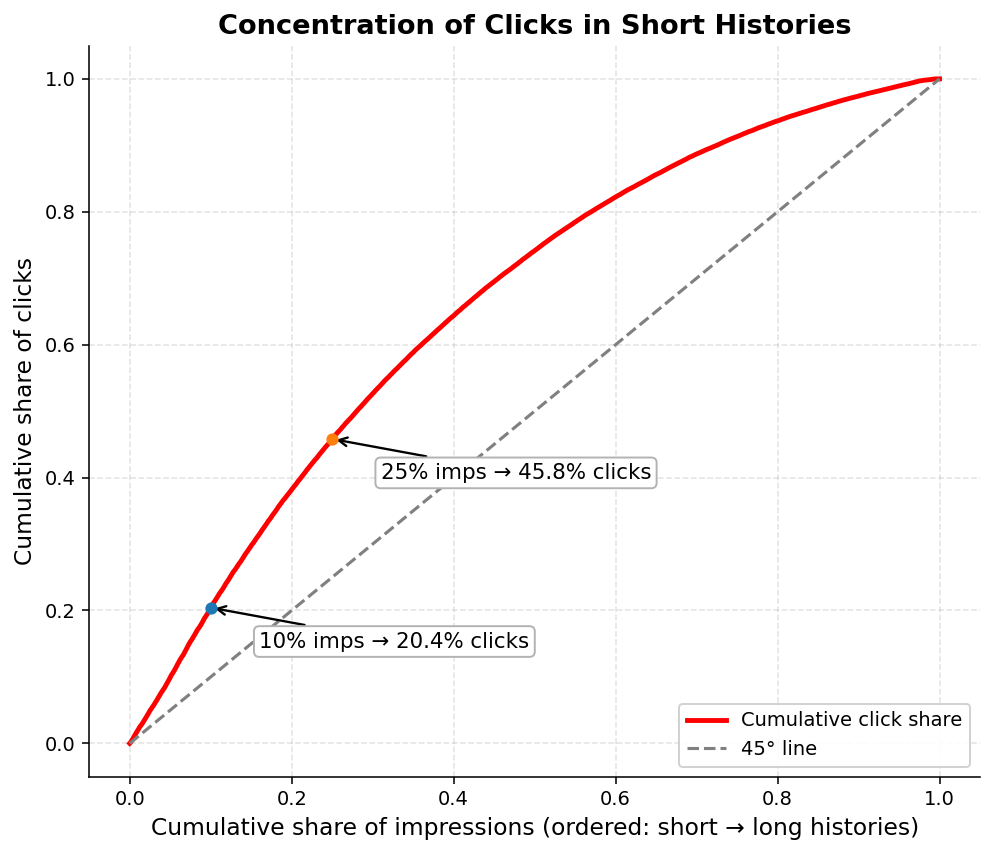

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "filtered_merged_dataset.csv"
USER_COL = "ANDROID_ID"
TIME_COL = "TIME"
CLICK_COL = "CLICK"

ANNOT_QUANT = [0.10, 0.25]

SAVE_DIR = "figures"
os.makedirs(SAVE_DIR, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.fancybox": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35
})

df = pd.read_csv(CSV_PATH, low_memory=False)
df["is_click"] = (pd.to_numeric(df[CLICK_COL], errors="coerce").fillna(0) > 0).astype(int)

if TIME_COL in df.columns:
    try:
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="raise")
        df = df.sort_values([USER_COL, TIME_COL], kind="mergesort")
    except Exception:
        df = df.reset_index().rename(columns={"index": "_row_order"})
        df = df.sort_values([USER_COL, "_row_order"], kind="mergesort")
else:
    df = df.reset_index().rename(columns={"index": "_row_order"})
    df = df.sort_values([USER_COL, "_row_order"], kind="mergesort")

df["history_len"] = df.groupby(USER_COL).cumcount()

def lorenz_curve_by_history(df, history_col="history_len", click_col="is_click"):
    dsort = df.sort_values(history_col, kind="mergesort")
    y_click = dsort[click_col].to_numpy()
    x = np.linspace(0.0, 1.0, len(dsort), endpoint=True)
    total_clicks = max(1, int(y_click.sum()))
    y = y_click.cumsum() / total_clicks
    auc = np.trapz(y, x)
    C = 2 * auc - 1
    return x, y, C

x, y, C = lorenz_curve_by_history(df, "history_len", "is_click")

fig1, ax1 = plt.subplots(figsize=(7.2, 6.2))
ax1.plot(x, y, linewidth=2.5, label="Cumulative click share", color="red")
ax1.plot([0, 1], [0, 1], linestyle="--", linewidth=1.6, label="45° line", color="grey")

for q in ANNOT_QUANT:
    yq = float(np.interp(q, x, y))
    ax1.scatter([q], [yq], s=28, zorder=5)
    ax1.annotate(
        f"{int(q*100)}% imps → {yq*100:.1f}% clicks",
        xy=(q, yq), xytext=(q + 0.06, yq - 0.06),
        arrowprops=dict(arrowstyle="->", lw=1.2),
        fontsize=11, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7")
    )

ax1.set_xlabel("Cumulative share of impressions (ordered: short → long histories)")
ax1.set_ylabel("Cumulative share of clicks")
ax1.set_title("Concentration of Clicks in Short Histories")
ax1.grid(True)
ax1.legend(loc="lower right", fontsize=10)

fig1.tight_layout()
fig1.show()
fig1.savefig("Fig_Lorenz_History.png", dpi=200, bbox_inches="tight")


## Figure 2(b): Predictive Power of Past Clicks for Future Engagement

This figure plots the click-through rate on the next impression as a function of the number of past clicks in a user’s history. Bubble sizes reflect the number of observations at each history level. The fitted weighted least squares regression and confidence band show a strong positive relationship, indicating that behavioral history rapidly becomes informative for predicting future engagement.

/tmp/ipykernel_2425417/3867680038.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = wls.params[1]
/tmp/ipykernel_2425417/3867680038.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval  = wls.pvalues[1]


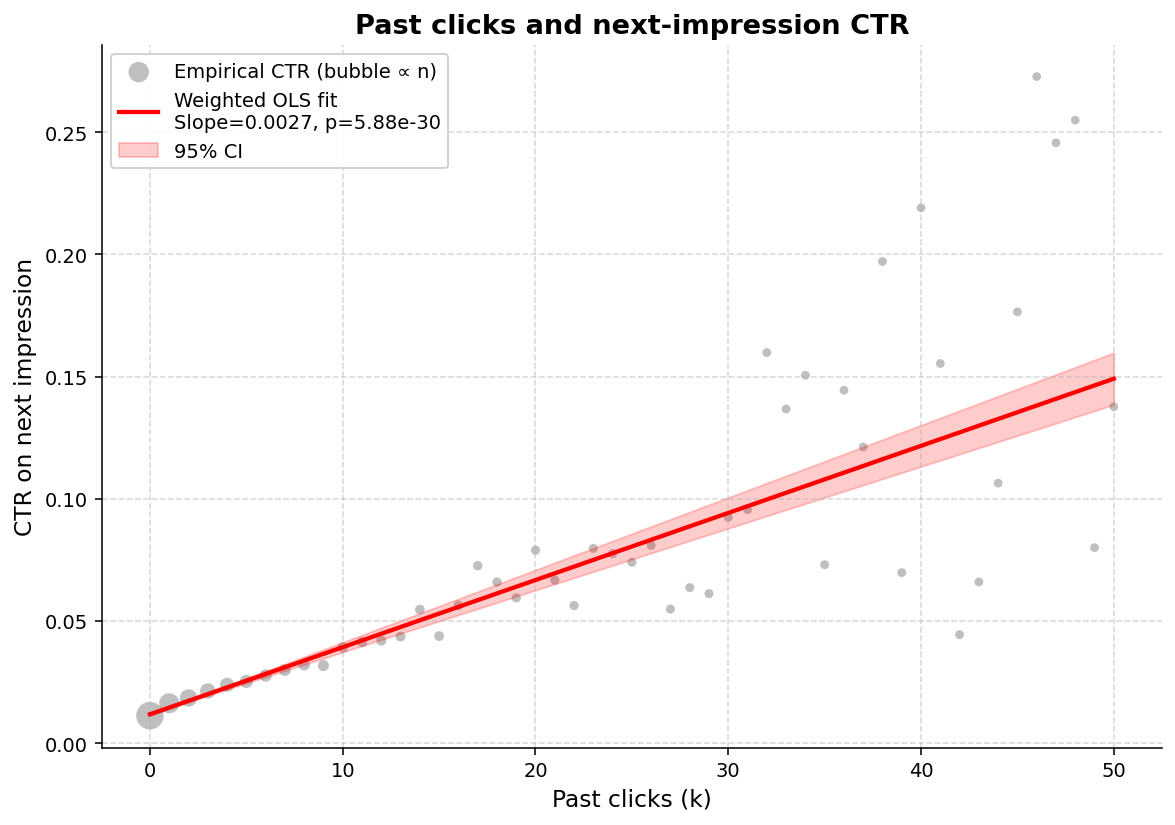

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

CSV_PATH = "filtered_merged_dataset.csv"
USER_COL = "ANDROID_ID"
TIME_COL = "TIME"
CLICK_COL = "CLICK"

MAX_PAST = 50
ALPHA = 0.05

df = pd.read_csv(CSV_PATH, low_memory=False)
df["is_click"] = (pd.to_numeric(df[CLICK_COL], errors="coerce").fillna(0) > 0).astype(int)

if TIME_COL in df.columns:
    try:
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="raise")
    except Exception:
        pass
    df = df.sort_values([USER_COL, TIME_COL], kind="mergesort")
else:
    df = df.reset_index().rename(columns={"index": "_row_order"})
    df = df.sort_values([USER_COL, "_row_order"], kind="mergesort")

df["prior_clicks"] = df.groupby(USER_COL)["is_click"].cumsum().shift(fill_value=0)

df["click_next"] = df.groupby(USER_COL)["is_click"].shift(-1)
df = df[df["click_next"].notna()].copy()
df["click_next"] = df["click_next"].astype(int)

agg = (
    df.groupby("prior_clicks")["click_next"]
      .agg(clicks="sum", n_obs="count")
      .reset_index()
)
agg["ctr_next"] = agg["clicks"] / agg["n_obs"]

if MAX_PAST is not None:
    agg = agg[agg["prior_clicks"] <= MAX_PAST].copy()

X = sm.add_constant(agg["prior_clicks"])
y = agg["ctr_next"].to_numpy()
w = agg["n_obs"].to_numpy().clip(min=1)

wls = sm.WLS(y, X, weights=w).fit()

x_grid = np.linspace(0, agg["prior_clicks"].max(), 200)
Xg = sm.add_constant(x_grid)
pred = wls.get_prediction(Xg).summary_frame(alpha=ALPHA)

y_mean = pred["mean"].clip(0, 1)
y_lo = pred["mean_ci_lower"].clip(0, 1)
y_hi = pred["mean_ci_upper"].clip(0, 1)

slope = wls.params[1]
pval = wls.pvalues[1]

plt.figure(figsize=(8.5, 6))

sizes = np.sqrt(agg["n_obs"].to_numpy())
sizes = 20 + 180 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)

plt.scatter(
    agg["prior_clicks"], agg["ctr_next"],
    s=sizes, alpha=0.5, color="gray", edgecolor="none",
    label="Empirical CTR (bubble ∝ n)"
)

plt.plot(
    x_grid, y_mean, color="red", linewidth=2.2,
    label=f"Weighted OLS fit\nSlope={slope:.4f}, p={pval:.3g}"
)
plt.fill_between(x_grid, y_lo, y_hi, color="red", alpha=0.2, label="95% CI")

plt.xlabel("Past clicks (k)")
plt.ylabel("CTR on next impression")
plt.title("Past clicks and next-impression CTR")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Fig_Past_Click.png", dpi=200, bbox_inches="tight")
plt.show()

# Policy Value Estimation via Inverse Propensity Scoring (IPS)

We evaluate the economic value of alternative information regimes, **contextual**, **geographical**, **behavioral**, and **geographical + behavioral**, using **Inverse Propensity Scoring (IPS)** applied to counterfactual predictions and estimated logging propensities. For each impression \( i \), we observe the logged action \( A_i \), realized outcome \( Y_i \), and the estimated propensity of the logging policy \( \hat\pi_D(a \mid i) \).

For a target policy \( \pi \), its value is estimated as
\[
\hat V_{\text{IPS}}(\pi)
= \frac{1}{n}\sum_{i=1}^n
\frac{\mathbf{1}\{A_i=\pi(i)\}}{\hat\pi_D(A_i\mid i)}\,Y_i,
\]
which reweights observed outcomes to correct for the discrepancy between the target policy and the historical logging policy. To ensure stability, we restrict evaluation to actions within the support of the logging policy and impose lower bounds on propensities.

We report IPS estimates for each information regime, along with effective sample size (ESS) diagnostics to assess variance inflation induced by reweighting. Statistical inference is conducted using standard errors, confidence intervals, and t-tests against the baseline click-through rate (CTR). This IPS-based framework provides an unbiased comparison of policy value across information regimes while explicitly accounting for the logged assignment mechanism.

## Value of Geogprahical Data (Table 3)

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats

EVAL_FILE = Path(f"Models/val_counterfactual_predictions_Geographical.csv")
ID_FILE = Path(f"Models/val_counterfactual_predictions_Geographical.csv")
OUT_CSV = Path("policy_evaluation_step_by_step_Geographical.csv")
PROP_FILE = Path("propensity_scores.csv")

EPSILON = 1e-9

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)

id_df = pd.read_csv(ID_FILE)
id_col = "Unique_ID" if "Unique_ID" in id_df.columns else id_df.columns[0]
eval_df = eval_df[eval_df["Unique_ID"].isin(id_df[id_col])].reset_index(drop=True)

REQ = {"Unique_ID", "Actual_Ad_ID", "Actual_Y"}
missing = REQ - set(eval_df.columns)
if missing:
    raise ValueError(f"eval file missing columns: {missing}")

cf_cols = sorted(
    [c for c in eval_df if c.startswith("cf_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
pi_cols = sorted(
    [c for c in prop_df if c.startswith("pi_hat_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
if len(cf_cols) != len(pi_cols):
    raise ValueError("Number of ads differs between CF outcomes and propensities")

K = len(cf_cols)
ad_ids = [int(c.rsplit("_", 1)[-1]) for c in cf_cols]
ad2idx = {a: i for i, a in enumerate(ad_ids)}

df = eval_df.merge(prop_df, on="Unique_ID", how="left", validate="1:1")
n = len(df)
μ_hat = df[cf_cols].to_numpy()
π_hat_D = df[pi_cols].fillna(0.0).to_numpy()

elig_mask = π_hat_D > EPSILON
elig_count = elig_mask.sum(axis=1)

df["elig_count"] = elig_count
df["elig_none"] = elig_count == 0

masked_μ = np.where(elig_mask, μ_hat, -np.inf)
greedy_idx = masked_μ.argmax(axis=1)
greedy_idx[df["elig_none"]] = -1
greedy_ad = np.where(greedy_idx == -1, -1, np.asarray(ad_ids)[greedy_idx])

df["greedy_ad_id"] = greedy_ad
df["greedy_mu"] = np.where(
    greedy_idx != -1, μ_hat[np.arange(n), greedy_idx], np.nan
)
df["greedy_pi_D"] = np.where(
    greedy_idx != -1, π_hat_D[np.arange(n), greedy_idx], np.nan
)

pure_greedy_idx = μ_hat.argmax(axis=1)
df["pure_greedy_ad_id"] = np.asarray(ad_ids)[pure_greedy_idx]
df["pure_greedy_mu"] = μ_hat[np.arange(n), pure_greedy_idx]

π_R = np.zeros_like(π_hat_D)
has_support = elig_count > 0
π_R[has_support] = elig_mask[has_support] / elig_count[has_support, None]

logged_idx = (
    df["Actual_Ad_ID"].map(ad2idx).fillna(-1).astype(int).to_numpy()
)
π_R_logged = np.where(logged_idx != -1, π_R[np.arange(n), logged_idx], 0.0)
df["uniform_p_logged_ad"] = π_R_logged

df["logged_ad_idx"] = logged_idx
df["logged_in_set"] = logged_idx != -1
df["logged_pi_D"] = np.where(
    df["logged_in_set"], π_hat_D[np.arange(n), logged_idx], 0.0
)
df["logged_mu"] = np.where(
    df["logged_in_set"], μ_hat[np.arange(n), logged_idx], np.nan
)

df["ips_greedy_match"] = (
    (df["greedy_ad_id"] == df["Actual_Ad_ID"]) & df["logged_in_set"]
)
df["ips_greedy_weight"] = np.where(
    df["ips_greedy_match"] & (df["logged_pi_D"] > EPSILON),
    1.0 / df["logged_pi_D"],
    0.0,
)
df["ips_greedy_term"] = df["ips_greedy_weight"] * df["Actual_Y"]

df["ips_uniform_weight"] = np.where(
    df["logged_pi_D"] > EPSILON,
    df["uniform_p_logged_ad"] / df["logged_pi_D"],
    0.0,
)
df["ips_uniform_term"] = df["ips_uniform_weight"] * df["Actual_Y"]

baseline = df["Actual_Y"].mean()
dm_greedy = df["greedy_mu"].mean(skipna=True)
dm_pure_greedy = df["pure_greedy_mu"].mean(skipna=True)
ips_greedy = df["ips_greedy_term"].mean()
ips_uniform = df["ips_uniform_term"].mean()

w = df["ips_greedy_weight"]
ess_greedy = (w.sum() ** 2) / (w**2).sum() if w.sum() else 0

def ci_mean(series, alpha=0.05):
    arr = series.to_numpy()
    m = arr.mean()
    se = arr.std(ddof=1) / np.sqrt(len(arr))
    df_ = len(arr) - 1
    t_crit = stats.t.ppf(1 - alpha / 2, df_)
    return m, se, m - t_crit * se, m + t_crit * se

def t_test_against_baseline(series, baseline_val):
    diff = series - baseline_val
    t_stat, p_val = stats.ttest_1samp(diff, popmean=0.0)
    se = diff.std(ddof=1) / np.sqrt(len(diff))
    ci = stats.t.interval(0.95, len(diff) - 1, loc=diff.mean(), scale=se)
    return diff.mean(), se, t_stat, p_val, ci

ips_g_mean, ips_g_se, ips_g_lo, ips_g_hi = ci_mean(df["ips_greedy_term"])
ips_u_mean, ips_u_se, ips_u_lo, ips_u_hi = ci_mean(df["ips_uniform_term"])

g_diff, g_se, g_t, g_p, g_ci = t_test_against_baseline(
    df["ips_greedy_term"], baseline
)
u_diff, u_se, u_t, u_p, u_ci = t_test_against_baseline(
    df["ips_uniform_term"], baseline
)

print("\n──────── SUMMARY ────────")
print(f"Rows / impressions                         : {n:,}")
print(f"Baseline CTR                               : {baseline:.6f}")
print(f"Deterministic – IPS                               : {ips_greedy:.6f}")
print(f"Random (support) – IPS                     : {ips_uniform:.6f}")
print(f"   ↳ Effective sample size (greedy IPS)    : {ess_greedy:.1f}")

print("\n──────── INFERENCE (95 % two-sided) ───────")
print(f"Deterministic IPS estimate      : {ips_g_mean:.6f}  ± {1.96 * ips_g_se:.6f}")
print(f"    CI                   : [{ips_g_lo:.6f}, {ips_g_hi:.6f}]")
print(f"Random IPS estimate     : {ips_u_mean:.6f}  ± {1.96 * ips_u_se:.6f}")
print(f"    CI                   : [{ips_u_lo:.6f}, {ips_u_hi:.6f}]")

print("\n──────── T-TEST vs baseline CTR ───────────")

def pretty(name, diff, se, t, p, ci):
    sign = "+" if diff >= 0 else ""
    print(f"{name:<12} Δ = {sign}{diff:.6f}  (se {se:.6f})")
    print(f"   t-stat = {t:.3f}   p-val = {p:.3g}")
    print(f"   CI95   = [{ci[0]:.6f}, {ci[1]:.6f}]")

pretty("Deterministic IPS", g_diff, g_se, g_t, g_p, g_ci)
pretty("Random IPS", u_diff, u_se, u_t, u_p, u_ci)

print("\n──────── RELATIVE LIFT vs baseline ───────")
for name, val in [
    ("Deterministic IPS", ips_greedy),
    ("Random IPS", ips_uniform),
]:
    lift = (val - baseline) / baseline * 100 if baseline else np.nan
    sign = "+" if lift >= 0 else ""
    print(f"{name:<16}: {sign}{lift:.2f}%   (Δ {val - baseline:+.6f})")


──────── SUMMARY ────────
Rows / impressions                         : 3,162,376
Baseline CTR                               : 0.017592
Deterministic – IPS                               : 0.022643
Random (support) – IPS                     : 0.016809
   ↳ Effective sample size (greedy IPS)    : 592426.6

──────── INFERENCE (95 % two-sided) ───────
Deterministic IPS estimate      : 0.022643  ± 0.000385
    CI                   : [0.022259, 0.023028]
Random IPS estimate     : 0.016809  ± 0.000139
    CI                   : [0.016670, 0.016949]

──────── T-TEST vs baseline CTR ───────────
Deterministic IPS Δ = +0.005051  (se 0.000196)
   t-stat = 25.749   p-val = 3.46e-146
   CI95   = [0.004667, 0.005436]
Random IPS   Δ = -0.000782  (se 0.000071)
   t-stat = -11.013   p-val = 3.33e-28
   CI95   = [-0.000922, -0.000643]

──────── RELATIVE LIFT vs baseline ───────
Deterministic IPS: +28.71%   (Δ +0.005051)
Random IPS      : -4.45%   (Δ -0.000782)


## Value of Contextual Data (Table 3)

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats

EVAL_FILE = Path(f"Models/val_counterfactual_predictions_Contextual.csv")
OUT_CSV = Path("policy_evaluation_step_by_step_Contextual.csv")
PROP_FILE = Path("propensity_scores.csv")

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)

EPSILON = 1e-9

ID_FILE = Path(f"Models/val_counterfactual_predictions_Contextual.csv")
id_df = pd.read_csv(ID_FILE)
id_col = "Unique_ID" if "Unique_ID" in id_df.columns else id_df.columns[0]
eval_df = eval_df[eval_df["Unique_ID"].isin(id_df[id_col])].reset_index(drop=True)

REQ = {"Unique_ID", "Actual_Ad_ID", "Actual_Y"}
missing = REQ - set(eval_df.columns)
if missing:
    raise ValueError(f"eval file missing columns: {missing}")

cf_cols = sorted(
    [c for c in eval_df if c.startswith("cf_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
pi_cols = sorted(
    [c for c in prop_df if c.startswith("pi_hat_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
if len(cf_cols) != len(pi_cols):
    raise ValueError("Number of ads differs between CF outcomes and propensities")

K = len(cf_cols)
ad_ids = [int(c.rsplit("_", 1)[-1]) for c in cf_cols]
ad2idx = {a: i for i, a in enumerate(ad_ids)}

df = eval_df.merge(prop_df, on="Unique_ID", how="left", validate="1:1")
n = len(df)
μ_hat = df[cf_cols].to_numpy()
π_hat_D = df[pi_cols].fillna(0.0).to_numpy()

elig_mask = π_hat_D > EPSILON
elig_count = elig_mask.sum(axis=1)

df["elig_count"] = elig_count
df["elig_none"] = elig_count == 0

masked_μ = np.where(elig_mask, μ_hat, -np.inf)
greedy_idx = masked_μ.argmax(axis=1)
greedy_idx[df["elig_none"]] = -1
greedy_ad = np.where(greedy_idx == -1, -1, np.asarray(ad_ids)[greedy_idx])

df["greedy_ad_id"] = greedy_ad
df["greedy_mu"] = np.where(greedy_idx != -1, μ_hat[np.arange(n), greedy_idx], np.nan)
df["greedy_pi_D"] = np.where(greedy_idx != -1, π_hat_D[np.arange(n), greedy_idx], np.nan)

pure_greedy_idx = μ_hat.argmax(axis=1)
df["pure_greedy_ad_id"] = np.asarray(ad_ids)[pure_greedy_idx]
df["pure_greedy_mu"] = μ_hat[np.arange(n), pure_greedy_idx]

π_R = np.zeros_like(π_hat_D)
has_support = elig_count > 0
π_R[has_support] = elig_mask[has_support] / elig_count[has_support, None]

logged_idx = df["Actual_Ad_ID"].map(ad2idx).fillna(-1).astype(int).to_numpy()
π_R_logged = np.where(logged_idx != -1, π_R[np.arange(n), logged_idx], 0.0)
df["uniform_p_logged_ad"] = π_R_logged

df["logged_ad_idx"] = logged_idx
df["logged_in_set"] = logged_idx != -1
df["logged_pi_D"] = np.where(
    df["logged_in_set"], π_hat_D[np.arange(n), logged_idx], 0.0
)
df["logged_mu"] = np.where(
    df["logged_in_set"], μ_hat[np.arange(n), logged_idx], np.nan
)

df["ips_greedy_match"] = (df["greedy_ad_id"] == df["Actual_Ad_ID"]) & df["logged_in_set"]
df["ips_greedy_weight"] = np.where(
    df["ips_greedy_match"] & (df["logged_pi_D"] > EPSILON),
    1.0 / df["logged_pi_D"],
    0.0,
)
df["ips_greedy_term"] = df["ips_greedy_weight"] * df["Actual_Y"]

df["ips_uniform_weight"] = np.where(
    df["logged_pi_D"] > EPSILON,
    df["uniform_p_logged_ad"] / df["logged_pi_D"],
    0.0,
)
df["ips_uniform_term"] = df["ips_uniform_weight"] * df["Actual_Y"]

baseline = df["Actual_Y"].mean()
baseline_p = df["Predicted_Y"].mean() if "Predicted_Y" in df.columns else np.nan

dm_greedy = df["greedy_mu"].mean(skipna=True)
dm_pure_greedy = df["pure_greedy_mu"].mean(skipna=True)
ips_greedy = df["ips_greedy_term"].mean()
ips_uniform = df["ips_uniform_term"].mean()

w = df["ips_greedy_weight"]
ess_greedy = (w.sum() ** 2) / (w ** 2).sum() if w.sum() else 0

def ci_mean(series, alpha=0.05):
    arr = series.to_numpy()
    m = arr.mean()
    se = arr.std(ddof=1) / np.sqrt(len(arr))
    df_ = len(arr) - 1
    t_crit = stats.t.ppf(1 - alpha / 2, df_)
    return m, se, m - t_crit * se, m + t_crit * se

def t_test(series, baseline_val):
    diff = series - baseline_val
    t_stat, p_val = stats.ttest_1samp(diff, 0.0)
    se = diff.std(ddof=1) / np.sqrt(len(diff))
    ci = stats.t.interval(0.95, len(diff) - 1, loc=diff.mean(), scale=se)
    return diff.mean(), se, t_stat, p_val, ci

g_diff, g_se, g_t, g_p, g_ci = t_test(df["ips_greedy_term"], baseline)
u_diff, u_se, u_t, u_p, u_ci = t_test(df["ips_uniform_term"], baseline)

ips_g_mean, ips_g_se, ips_g_lo, ips_g_hi = ci_mean(df["ips_greedy_term"])
ips_u_mean, ips_u_se, ips_u_lo, ips_u_hi = ci_mean(df["ips_uniform_term"])

print(f"\n✔  step-by-step dataframe would be written → {OUT_CSV}")

print("\n──────── SUMMARY ────────")
print(f"Rows / impressions                         : {n:,}")
print(f"Baseline CTR                               : {baseline:.6f}")
if not np.isnan(baseline_p):
    print(f"Baseline Predicted CTR                     : {baseline_p:.6f}")
print(f"Deterministic – IPS                               : {ips_greedy:.6f}")
print(f"Uniform-random (support) – IPS             : {ips_uniform:.6f}")
print(f"   ↳ Effective sample size (greedy IPS)    : {ess_greedy:.1f}")

print("\n──────── INFERENCE (95 % two-sided) ───────")
print(f"Deterministic IPS estimate      : {ips_g_mean:.6f}  ± {1.96*ips_g_se:.6f}")
print(f"    CI                   : [{ips_g_lo:.6f}, {ips_g_hi:.6f}]")
print(f"Uniform IPS estimate     : {ips_u_mean:.6f}  ± {1.96*ips_u_se:.6f}")
print(f"    CI                   : [{ips_u_lo:.6f}, {ips_u_hi:.6f}]")

print("\n──────── T-TEST vs baseline CTR ───────────")
def pretty(name, diff, se, t, p, ci):
    sign = "+" if diff >= 0 else ""
    print(f"{name:<12} Δ = {sign}{diff:.6f}  (se {se:.6f})")
    print(f"   t-stat = {t:.3f}   p-val = {p:.3g}")
    print(f"   CI95   = [{ci[0]:.6f}, {ci[1]:.6f}]")

pretty("Deterministic IPS", g_diff, g_se, g_t, g_p, g_ci)
pretty("Uniform IPS", u_diff, u_se, u_t, u_p, u_ci)

print("\n──────── RELATIVE LIFT vs baseline ───────")
for name, val in [
    ("Deterministic IPS", ips_greedy),
    ("Uniform IPS", ips_uniform),
]:
    lift = (val - baseline) / baseline * 100 if baseline else np.nan
    sign = "+" if lift >= 0 else ""
    print(f"{name:<16}: {sign}{lift:.2f}%   (Δ {val - baseline:+.6f})")


✔  step-by-step dataframe would be written → policy_evaluation_step_by_step_Beh3.csv

──────── SUMMARY ────────
Rows / impressions                         : 3,162,376
Baseline CTR                               : 0.017592
Baseline Predicted CTR                     : 0.016865
Deterministic – IPS                               : 0.021187
Uniform-random (support) – IPS             : 0.016809
   ↳ Effective sample size (greedy IPS)    : 542746.9

──────── INFERENCE (95 % two-sided) ───────
Deterministic IPS estimate      : 0.021187  ± 0.000375
    CI                   : [0.020812, 0.021563]
Uniform IPS estimate     : 0.016809  ± 0.000139
    CI                   : [0.016670, 0.016949]

──────── T-TEST vs baseline CTR ───────────
Deterministic IPS Δ = +0.003596  (se 0.000191)
   t-stat = 18.782   p-val = 1.06e-78
   CI95   = [0.003220, 0.003971]
Uniform IPS  Δ = -0.000782  (se 0.000071)
   t-stat = -11.013   p-val = 3.33e-28
   CI95   = [-0.000922, -0.000643]

──────── RELATIVE LIFT vs basel

## Value of Behavioral Data (Table 3)

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats


EVAL_FILE = Path(f"Models0/val_counterfactual_predictions_Behavioral.csv")
OUT_CSV = Path("policy_evaluation_step_by_step_Behavioral.csv")
PROP_FILE = Path("propensity_scores.csv")
PROCESSED_FILE = Path("preprocessed_test_data.csv")

EPSILON = 1e-9

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)

REQ = {"Unique_ID", "Actual_Ad_ID", "Actual_Y"}
missing = REQ - set(eval_df.columns)
if missing:
    raise ValueError(f"eval file missing columns: {missing}")

cf_cols = sorted(
    [c for c in eval_df if c.startswith("cf_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
pi_cols = sorted(
    [c for c in prop_df if c.startswith("pi_hat_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
if len(cf_cols) != len(pi_cols):
    raise ValueError("Number of ads differs between CF outcomes and propensities")

K = len(cf_cols)
ad_ids = [int(c.rsplit("_", 1)[-1]) for c in cf_cols]
ad2idx = {a: i for i, a in enumerate(ad_ids)}

df = eval_df.merge(prop_df, on="Unique_ID", how="left", validate="1:1")

proc_df = pd.read_csv(PROCESSED_FILE, low_memory=False)
uid_col = "Unique_ID" if "Unique_ID" in proc_df.columns else proc_df.columns[0]
cols_to_merge = [uid_col] + (["ANDROID_ID"] if "ANDROID_ID" in proc_df.columns else [])
if "ANDROID_ID" not in proc_df.columns:
    raise ValueError("processed_test_data.csv must contain an ANDROID_ID column.")
df = df.merge(
    proc_df[cols_to_merge].rename(columns={uid_col: "Unique_ID"}),
    on="Unique_ID",
    how="left",
    validate="1:1",
)

n = len(df)
μ_hat = df[cf_cols].to_numpy()
π_hat_D = df[pi_cols].fillna(0.0).to_numpy()

if "ANDROID_ID" in df.columns:
    df["cluster_id"] = df["ANDROID_ID"].fillna(df["Unique_ID"])
else:
    df["cluster_id"] = df["Unique_ID"]

elig_mask = π_hat_D > EPSILON
elig_count = elig_mask.sum(axis=1)

df["elig_count"] = elig_count
df["elig_none"] = elig_count == 0

masked_μ = np.where(elig_mask, μ_hat, -np.inf)
greedy_idx = masked_μ.argmax(axis=1)
greedy_idx[df["elig_none"]] = -1
greedy_ad = np.where(greedy_idx == -1, -1, np.asarray(ad_ids)[greedy_idx])

df["greedy_ad_id"] = greedy_ad
df["greedy_mu"] = np.where(greedy_idx != -1, μ_hat[np.arange(n), greedy_idx], np.nan)
df["greedy_pi_D"] = np.where(greedy_idx != -1, π_hat_D[np.arange(n), greedy_idx], np.nan)

pure_greedy_idx = μ_hat.argmax(axis=1)
df["pure_greedy_ad_id"] = np.asarray(ad_ids)[pure_greedy_idx]
df["pure_greedy_mu"] = μ_hat[np.arange(n), pure_greedy_idx]

π_R = np.zeros_like(π_hat_D)
has_support = elig_count > 0
π_R[has_support] = elig_mask[has_support] / elig_count[has_support, None]

logged_idx = df["Actual_Ad_ID"].map(ad2idx).fillna(-1).astype(int).to_numpy()
π_R_logged = np.where(logged_idx != -1, π_R[np.arange(n), logged_idx], 0.0)
df["uniform_p_logged_ad"] = π_R_logged

df["logged_ad_idx"] = logged_idx
df["logged_in_set"] = logged_idx != -1
df["logged_pi_D"] = np.where(
    df["logged_in_set"], π_hat_D[np.arange(n), logged_idx], 0.0
)
df["logged_mu"] = np.where(
    df["logged_in_set"], μ_hat[np.arange(n), logged_idx], np.nan
)

df["ips_greedy_match"] = (df["greedy_ad_id"] == df["Actual_Ad_ID"]) & df["logged_in_set"]
df["ips_greedy_weight"] = np.where(
    df["ips_greedy_match"] & (df["logged_pi_D"] > EPSILON),
    1.0 / df["logged_pi_D"],
    0.0,
)
df["ips_greedy_term"] = df["ips_greedy_weight"] * df["Actual_Y"]

df["ips_uniform_weight"] = np.where(
    df["logged_pi_D"] > EPSILON,
    df["uniform_p_logged_ad"] / df["logged_pi_D"],
    0.0,
)
df["ips_uniform_term"] = df["ips_uniform_weight"] * df["Actual_Y"]

baseline = df["Actual_Y"].mean()
baseline_p = df["Predicted_Y"].mean() if "Predicted_Y" in df.columns else np.nan

dm_greedy = df["greedy_mu"].mean(skipna=True)
dm_pure_greedy = df["pure_greedy_mu"].mean(skipna=True)
ips_greedy = df["ips_greedy_term"].mean()
ips_uniform = df["ips_uniform_term"].mean()

w = df["ips_greedy_weight"]
ess_greedy = (w.sum() ** 2) / (w ** 2).sum() if w.sum() else 0

def ci_mean(series, alpha=0.05):
    x = series.to_numpy()
    c = df.loc[series.index, "cluster_id"].to_numpy()
    mask = np.isfinite(x)
    x, c = x[mask], c[mask]
    N = x.size
    m = x.mean()
    u = x - m
    S = pd.Series(u).groupby(pd.Series(c)).sum().to_numpy()
    G = S.size
    K = 1
    if G > 1 and N > K:
        factor = (G / (G - 1)) * ((N - 1) / (N - K))
    else:
        factor = 1.0
    var_cr = factor * (S @ S) / (N ** 2)
    se_cr = np.sqrt(var_cr)
    if G > 1:
        t_crit = stats.t.ppf(1 - alpha / 2, G - 1)
        lo, hi = m - t_crit * se_cr, m + t_crit * se_cr
    else:
        lo, hi = np.nan, np.nan
    return m, se_cr, lo, hi

def t_test(series, baseline_val):
    diff = series - baseline_val
    x = diff.to_numpy()
    c = df.loc[series.index, "cluster_id"].to_numpy()
    mask = np.isfinite(x)
    x, c = x[mask], c[mask]
    N = x.size
    m = x.mean()
    u = x - m
    S = pd.Series(u).groupby(pd.Series(c)).sum().to_numpy()
    G = S.size
    K = 1
    if G > 1 and N > K:
        factor = (G / (G - 1)) * ((N - 1) / (N - K))
    else:
        factor = 1.0
    var_cr = factor * (S @ S) / (N ** 2)
    se_cr = np.sqrt(var_cr)
    if G > 1 and se_cr > 0:
        t_stat = m / se_cr
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=G - 1))
        t_crit = stats.t.ppf(0.975, df=G - 1)
        ci = (m - t_crit * se_cr, m + t_crit * se_cr)
    else:
        t_stat, p_val = np.nan, np.nan
        ci = (np.nan, np.nan)
    return m, se_cr, t_stat, p_val, ci

g_diff, g_se, g_t, g_p, g_ci = t_test(df["ips_greedy_term"], baseline)
u_diff, u_se, u_t, u_p, u_ci = t_test(df["ips_uniform_term"], baseline)

ips_g_mean, ips_g_se, ips_g_lo, ips_g_hi = ci_mean(df["ips_greedy_term"])
ips_u_mean, ips_u_se, ips_u_lo, ips_u_hi = ci_mean(df["ips_uniform_term"])


print("\n──────── SUMMARY ────────")
print(f"Rows / impressions                         : {n:,}")
print(f"Baseline CTR                               : {baseline:.6f}")
if not np.isnan(baseline_p):
    print(f"Baseline Predicted CTR                     : {baseline_p:.6f}")
print(f"Deterministic – IPS                               : {ips_greedy:.6f}")
print(f"Random (support) – IPS             : {ips_uniform:.6f}")
print(f"   ↳ Effective sample size (greedy IPS)    : {ess_greedy:.1f}")

print("\n──────── INFERENCE (95 % two-sided) ───────")
print(f"Deterministic IPS estimate      : {ips_g_mean:.6f}  ± {1.96*ips_g_se:.6f}")
print(f"    CI                   : [{ips_g_lo:.6f}, {ips_g_hi:.6f}]")
print(f"Random IPS estimate     : {ips_u_mean:.6f}  ± {1.96*ips_u_se:.6f}")
print(f"    CI                   : [{ips_u_lo:.6f}, {ips_u_hi:.6f}]")

print("\n──────── T-TEST vs baseline CTR ───────────")
def pretty(name, diff, se, t, p, ci):
    sign = "+" if diff >= 0 else ""
    print(f"{name:<12} Δ = {sign}{diff:.6f}  (se {se:.6f})")
    print(f"   t-stat = {t:.3f}   p-val = {p:.3g}")
    print(f"   CI95   = [{ci[0]:.6f}, {ci[1]:.6f}]")

pretty("Deterministic IPS", g_diff, g_se, g_t, g_p, g_ci)
pretty("Random IPS", u_diff, u_se, u_t, u_p, u_ci)

print("\n──────── RELATIVE LIFT vs baseline ───────")
for name, val in [
    ("Deterministic IPS", ips_greedy),
    ("Random IPS", ips_uniform),
]:
    lift = (val - baseline) / baseline * 100 if baseline else np.nan
    sign = "+" if lift >= 0 else ""
    print(f"{name:<16}: {sign}{lift:.2f}%   (Δ {val - baseline:+.6f})")


──────── SUMMARY ────────
Rows / impressions                         : 3,162,376
Baseline CTR                               : 0.017592
Baseline Predicted CTR                     : 0.019637
Deterministic – IPS                               : 0.022918
Random (support) – IPS             : 0.016809
   ↳ Effective sample size (greedy IPS)    : 555871.4

──────── INFERENCE (95 % two-sided) ───────
Deterministic IPS estimate      : 0.022918  ± 0.000531
    CI                   : [0.022387, 0.023448]
Random IPS estimate     : 0.016809  ± 0.000268
    CI                   : [0.016541, 0.017077]

──────── T-TEST vs baseline CTR ───────────
Deterministic IPS Δ = +0.005326  (se 0.000271)
   t-stat = 19.675   p-val = 0
   CI95   = [0.004795, 0.005857]
Random IPS   Δ = -0.000782  (se 0.000137)
   t-stat = -5.721   p-val = 1.06e-08
   CI95   = [-0.001050, -0.000514]

──────── RELATIVE LIFT vs baseline ───────
Deterministic IPS: +30.28%   (Δ +0.005326)
Random IPS      : -4.45%   (Δ -0.000782)


## Value of Behavioral + Geographical Data (Table 3)

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats


EVAL_FILE = Path(f"Models2/val_counterfactual_predictions_BehavioralGeographical.csv")
OUT_CSV = Path("policy_evaluation_step_by_step_BehavioralGeographical.csv")
PROP_FILE = Path("propensity_scores.csv")
PROCESSED_FILE = Path("preprocessed_test_data.csv")

EPSILON = 1e-9

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)

REQ = {"Unique_ID", "Actual_Ad_ID", "Actual_Y"}
missing = REQ - set(eval_df.columns)
if missing:
    raise ValueError(f"eval file missing columns: {missing}")

cf_cols = sorted(
    [c for c in eval_df if c.startswith("cf_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
pi_cols = sorted(
    [c for c in prop_df if c.startswith("pi_hat_ad_")],
    key=lambda s: int(s.rsplit("_", 1)[-1]),
)
if len(cf_cols) != len(pi_cols):
    raise ValueError("Number of ads differs between CF outcomes and propensities")

K = len(cf_cols)
ad_ids = [int(c.rsplit("_", 1)[-1]) for c in cf_cols]
ad2idx = {a: i for i, a in enumerate(ad_ids)}

df = eval_df.merge(prop_df, on="Unique_ID", how="left", validate="1:1")

proc_df = pd.read_csv(PROCESSED_FILE, low_memory=False)
uid_col = "Unique_ID" if "Unique_ID" in proc_df.columns else proc_df.columns[0]
cols_to_merge = [uid_col] + (["ANDROID_ID"] if "ANDROID_ID" in proc_df.columns else [])
if "ANDROID_ID" not in proc_df.columns:
    raise ValueError("processed_test_data.csv must contain an ANDROID_ID column.")
df = df.merge(
    proc_df[cols_to_merge].rename(columns={uid_col: "Unique_ID"}),
    on="Unique_ID",
    how="left",
    validate="1:1",
)

n = len(df)
μ_hat = df[cf_cols].to_numpy()
π_hat_D = df[pi_cols].fillna(0.0).to_numpy()

if "ANDROID_ID" in df.columns:
    df["cluster_id"] = df["ANDROID_ID"].fillna(df["Unique_ID"])
else:
    df["cluster_id"] = df["Unique_ID"]

elig_mask = π_hat_D > EPSILON
elig_count = elig_mask.sum(axis=1)

df["elig_count"] = elig_count
df["elig_none"] = elig_count == 0

masked_μ = np.where(elig_mask, μ_hat, -np.inf)
greedy_idx = masked_μ.argmax(axis=1)
greedy_idx[df["elig_none"]] = -1
greedy_ad = np.where(greedy_idx == -1, -1, np.asarray(ad_ids)[greedy_idx])

df["greedy_ad_id"] = greedy_ad
df["greedy_mu"] = np.where(greedy_idx != -1, μ_hat[np.arange(n), greedy_idx], np.nan)
df["greedy_pi_D"] = np.where(greedy_idx != -1, π_hat_D[np.arange(n), greedy_idx], np.nan)

pure_greedy_idx = μ_hat.argmax(axis=1)
df["pure_greedy_ad_id"] = np.asarray(ad_ids)[pure_greedy_idx]
df["pure_greedy_mu"] = μ_hat[np.arange(n), pure_greedy_idx]

π_R = np.zeros_like(π_hat_D)
has_support = elig_count > 0
π_R[has_support] = elig_mask[has_support] / elig_count[has_support, None]

logged_idx = df["Actual_Ad_ID"].map(ad2idx).fillna(-1).astype(int).to_numpy()
π_R_logged = np.where(logged_idx != -1, π_R[np.arange(n), logged_idx], 0.0)
df["uniform_p_logged_ad"] = π_R_logged

df["logged_ad_idx"] = logged_idx
df["logged_in_set"] = logged_idx != -1
df["logged_pi_D"] = np.where(
    df["logged_in_set"], π_hat_D[np.arange(n), logged_idx], 0.0
)
df["logged_mu"] = np.where(
    df["logged_in_set"], μ_hat[np.arange(n), logged_idx], np.nan
)

df["ips_greedy_match"] = (df["greedy_ad_id"] == df["Actual_Ad_ID"]) & df["logged_in_set"]
df["ips_greedy_weight"] = np.where(
    df["ips_greedy_match"] & (df["logged_pi_D"] > EPSILON),
    1.0 / df["logged_pi_D"],
    0.0,
)
df["ips_greedy_term"] = df["ips_greedy_weight"] * df["Actual_Y"]

df["ips_uniform_weight"] = np.where(
    df["logged_pi_D"] > EPSILON,
    df["uniform_p_logged_ad"] / df["logged_pi_D"],
    0.0,
)
df["ips_uniform_term"] = df["ips_uniform_weight"] * df["Actual_Y"]

baseline = df["Actual_Y"].mean()
baseline_p = df["Predicted_Y"].mean() if "Predicted_Y" in df.columns else np.nan

dm_greedy = df["greedy_mu"].mean(skipna=True)
dm_pure_greedy = df["pure_greedy_mu"].mean(skipna=True)
ips_greedy = df["ips_greedy_term"].mean()
ips_uniform = df["ips_uniform_term"].mean()

w = df["ips_greedy_weight"]
ess_greedy = (w.sum() ** 2) / (w ** 2).sum() if w.sum() else 0

def ci_mean(series, alpha=0.05):
    x = series.to_numpy()
    c = df.loc[series.index, "cluster_id"].to_numpy()
    mask = np.isfinite(x)
    x, c = x[mask], c[mask]
    N = x.size
    m = x.mean()
    u = x - m
    S = pd.Series(u).groupby(pd.Series(c)).sum().to_numpy()
    G = S.size
    K = 1
    if G > 1 and N > K:
        factor = (G / (G - 1)) * ((N - 1) / (N - K))
    else:
        factor = 1.0
    var_cr = factor * (S @ S) / (N ** 2)
    se_cr = np.sqrt(var_cr)
    if G > 1:
        t_crit = stats.t.ppf(1 - alpha / 2, G - 1)
        lo, hi = m - t_crit * se_cr, m + t_crit * se_cr
    else:
        lo, hi = np.nan, np.nan
    return m, se_cr, lo, hi

def t_test(series, baseline_val):
    diff = series - baseline_val
    x = diff.to_numpy()
    c = df.loc[series.index, "cluster_id"].to_numpy()
    mask = np.isfinite(x)
    x, c = x[mask], c[mask]
    N = x.size
    m = x.mean()
    u = x - m
    S = pd.Series(u).groupby(pd.Series(c)).sum().to_numpy()
    G = S.size
    K = 1
    if G > 1 and N > K:
        factor = (G / (G - 1)) * ((N - 1) / (N - K))
    else:
        factor = 1.0
    var_cr = factor * (S @ S) / (N ** 2)
    se_cr = np.sqrt(var_cr)
    if G > 1 and se_cr > 0:
        t_stat = m / se_cr
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=G - 1))
        t_crit = stats.t.ppf(0.975, df=G - 1)
        ci = (m - t_crit * se_cr, m + t_crit * se_cr)
    else:
        t_stat, p_val = np.nan, np.nan
        ci = (np.nan, np.nan)
    return m, se_cr, t_stat, p_val, ci

def cr_ci_mean(series, clusters, alpha=0.05):
    x = pd.Series(series).to_numpy()
    c = pd.Series(clusters).to_numpy()
    mask = np.isfinite(x)
    x, c = x[mask], c[mask]
    N = x.size
    m = x.mean()
    u = x - m
    S = pd.Series(u).groupby(pd.Series(c)).sum().to_numpy()
    G = S.size
    K = 1
    if G > 1 and N > K:
        factor = (G / (G - 1)) * ((N - 1) / (N - K))
    else:
        factor = 1.0
    var_cr = factor * (S @ S) / (N ** 2)
    se_cr = np.sqrt(var_cr)
    if G > 1:
        tcrit = stats.t.ppf(1 - alpha / 2, G - 1)
        lo, hi = m - tcrit * se_cr, m + tcrit * se_cr
    else:
        lo, hi = np.nan, np.nan
    return m, se_cr, lo, hi, G, N

def cr_t_test(series, baseline_val, clusters, alpha=0.05):
    diff = pd.Series(series).to_numpy() - baseline_val
    c = pd.Series(clusters).to_numpy()
    mask = np.isfinite(diff)
    diff, c = diff[mask], c[mask]
    m, se_cr, lo, hi, G, N = cr_ci_mean(diff, c, alpha=alpha)
    if G > 1 and np.isfinite(se_cr) and se_cr > 0:
        t_stat = m / se_cr
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=G - 1))
    else:
        t_stat, p_val = np.nan, np.nan
    return m, se_cr, t_stat, p_val, (lo, hi), G, N

g_diff, g_se, g_t, g_p, g_ci = t_test(df["ips_greedy_term"], baseline)
u_diff, u_se, u_t, u_p, u_ci = t_test(df["ips_uniform_term"], baseline)

ips_g_mean, ips_g_se, ips_g_lo, ips_g_hi = ci_mean(df["ips_greedy_term"])
ips_u_mean, ips_u_se, ips_u_lo, ips_u_hi = ci_mean(df["ips_uniform_term"])

cr_g_mean, cr_g_se, cr_g_lo, cr_g_hi, Gg, Ng = cr_ci_mean(
    df["ips_greedy_term"], df["cluster_id"]
)
cr_u_mean, cr_u_se, cr_u_lo, cr_u_hi, Gu, Nu = cr_ci_mean(
    df["ips_uniform_term"], df["cluster_id"]
)

g_diff_cr, g_se_cr, g_t_cr, g_p_cr, g_ci_cr, Gg2, Ng2 = cr_t_test(
    df["ips_greedy_term"], baseline, df["cluster_id"]
)
u_diff_cr, u_se_cr, u_t_cr, u_p_cr, u_ci_cr, Gu2, Nu2 = cr_t_test(
    df["ips_uniform_term"], baseline, df["cluster_id"]
)

print("\n──────── SUMMARY ────────")
print(f"Rows / impressions                         : {n:,}")
print(f"Baseline CTR                               : {baseline:.6f}")
if not np.isnan(baseline_p):
    print(f"Baseline Predicted CTR                     : {baseline_p:.6f}")
print(f"Deterministic – IPS                               : {ips_greedy:.6f}")
print(f"Random (support) – IPS             : {ips_uniform:.6f}")
print(f"   ↳ Effective sample size (greedy IPS)    : {ess_greedy:.1f}")

print("\n──────── INFERENCE (95 % two-sided) ───────")
print(f"Deterministic IPS estimate      : {ips_g_mean:.6f}  ± {1.96*ips_g_se:.6f}")
print(f"    CI                   : [{ips_g_lo:.6f}, {ips_g_hi:.6f}]")
print(f"Random IPS estimate     : {ips_u_mean:.6f}  ± {1.96*ips_u_se:.6f}")
print(f"    CI                   : [{ips_u_lo:.6f}, {ips_u_hi:.6f}]")

print("\n──────── INFERENCE (cluster-robust, 95 % two-sided) ───────")
print(f"Deterministic IPS estimate      : {cr_g_mean:.6f}  ± {1.96*cr_g_se:.6f}")
print(f"    CI                   : [{cr_g_lo:.6f}, {cr_g_hi:.6f}]  (clusters={Gg})")
print(f"Random IPS estimate     : {cr_u_mean:.6f}  ± {1.96*cr_u_se:.6f}")
print(f"    CI                   : [{cr_u_lo:.6f}, {cr_u_hi:.6f}]  (clusters={Gu})")

print("\n──────── T-TEST vs baseline CTR ───────────")
def pretty(name, diff, se, t, p, ci):
    sign = "+" if diff >= 0 else ""
    print(f"{name:<12} Δ = {sign}{diff:.6f}  (se {se:.6f})")
    print(f"   t-stat = {t:.3f}   p-val = {p:.3g}")
    print(f"   CI95   = [{ci[0]:.6f}, {ci[1]:.6f}]")

pretty("Deterministic IPS", g_diff, g_se, g_t, g_p, g_ci)
pretty("Random IPS", u_diff, u_se, u_t, u_p, u_ci)

print("\n──────── T-TEST vs baseline CTR (cluster-robust) ───────────")
pretty("Deterministic IPS", g_diff_cr, g_se_cr, g_t_cr, g_p_cr, g_ci_cr)
pretty("Random IPS", u_diff_cr, u_se_cr, u_t_cr, u_p_cr, u_ci_cr)

print("\n──────── RELATIVE LIFT vs baseline ───────")
for name, val in [
    ("Deterministic IPS", ips_greedy),
    ("Random IPS", ips_uniform),
]:
    lift = (val - baseline) / baseline * 100 if baseline else np.nan
    sign = "+" if lift >= 0 else ""
    print(f"{name:<16}: {sign}{lift:.2f}%   (Δ {val - baseline:+.6f})")


──────── SUMMARY ────────
Rows / impressions                         : 3,162,376
Baseline CTR                               : 0.017592
Baseline Predicted CTR                     : 0.018437
Deterministic – IPS                               : 0.024883
Random (support) – IPS             : 0.016809
   ↳ Effective sample size (greedy IPS)    : 760316.2

──────── INFERENCE (95 % two-sided) ───────
Deterministic IPS estimate      : 0.024883  ± 0.000518
    CI                   : [0.024366, 0.025401]
Random IPS estimate     : 0.016809  ± 0.000268
    CI                   : [0.016541, 0.017077]

──────── INFERENCE (cluster-robust, 95 % two-sided) ───────
Deterministic IPS estimate      : 0.024883  ± 0.000518
    CI                   : [0.024366, 0.025401]  (clusters=141595)
Random IPS estimate     : 0.016809  ± 0.000268
    CI                   : [0.016541, 0.017077]  (clusters=141595)

──────── T-TEST vs baseline CTR ───────────
Deterministic IPS Δ = +0.007292  (se 0.000264)
   t-stat = 27.61

## Figure 6: Policy Value Across Impression Depth and Information Regimes

This figure plots IPS-estimated click-through rates (CTR) as a function of impression depth, comparing policies derived from different information regimes. Panels contrast **Contextual vs. Geographical** policies and **Behavioral vs. Geo+Behavioral** policies, with the dashed line indicating the baseline CTR from logged data.

Impressions are grouped into quantile bins of user history depth (up to the first 150 impressions), and policy values are computed via inverse propensity scoring within each bin. Shaded regions highlight the gap between competing policies and their deviation from the baseline. The figure illustrates how the relative value of additional information evolves as behavioral histories become richer.


✓ Saved → ctr_depth_C_vs_G.png
✓ Saved → ctr_depth_B_vs_GB.png


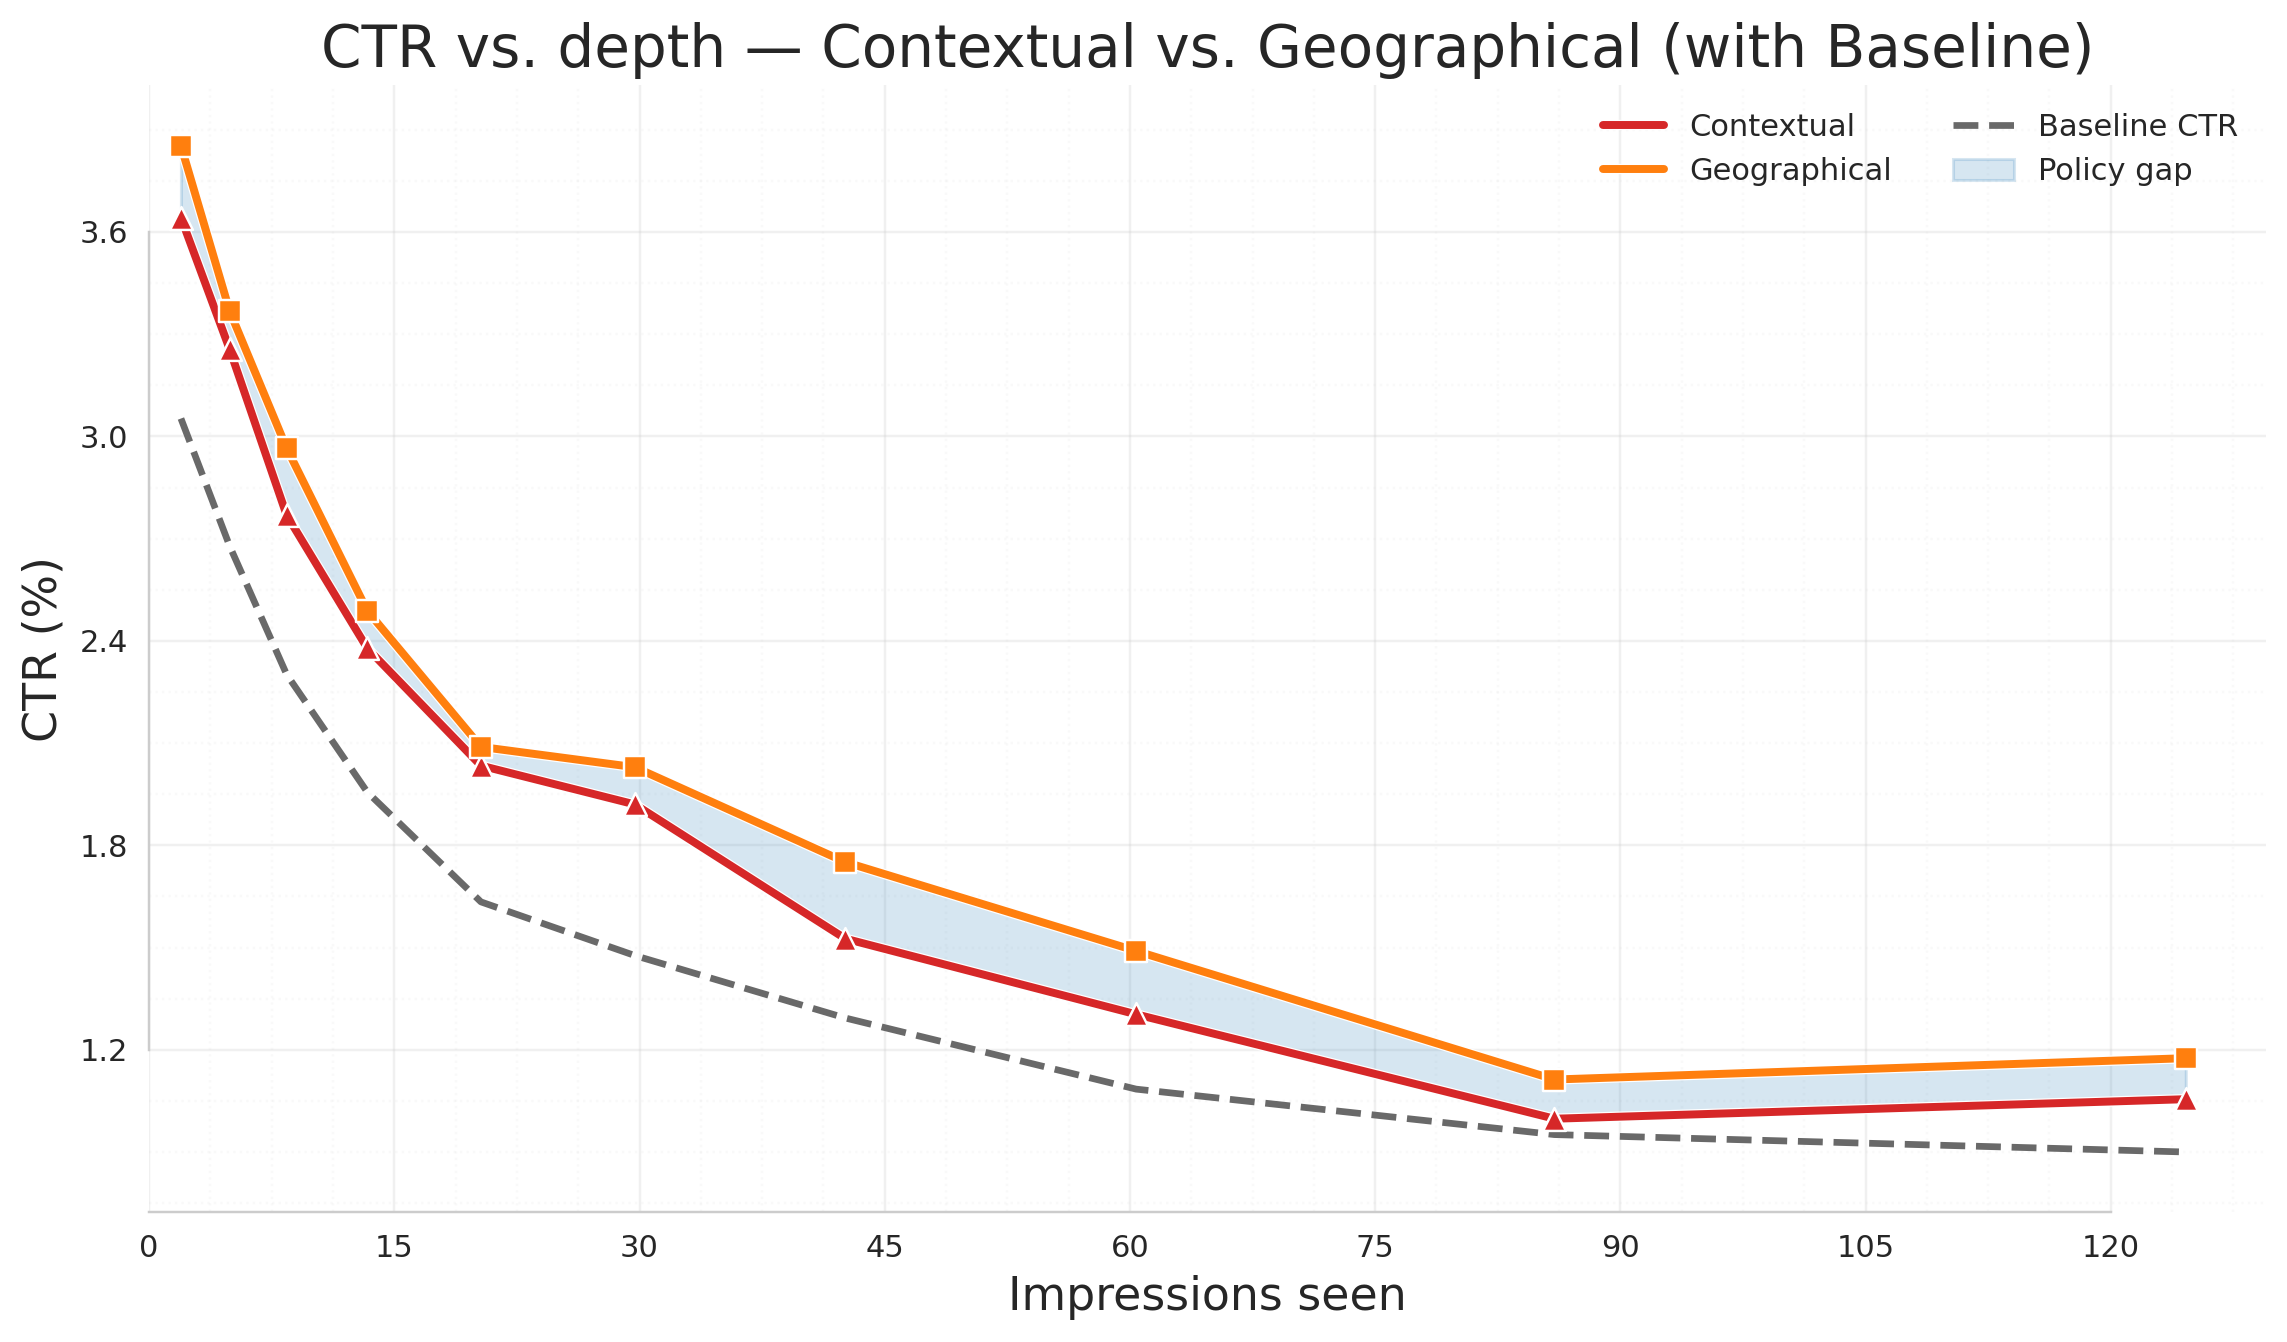

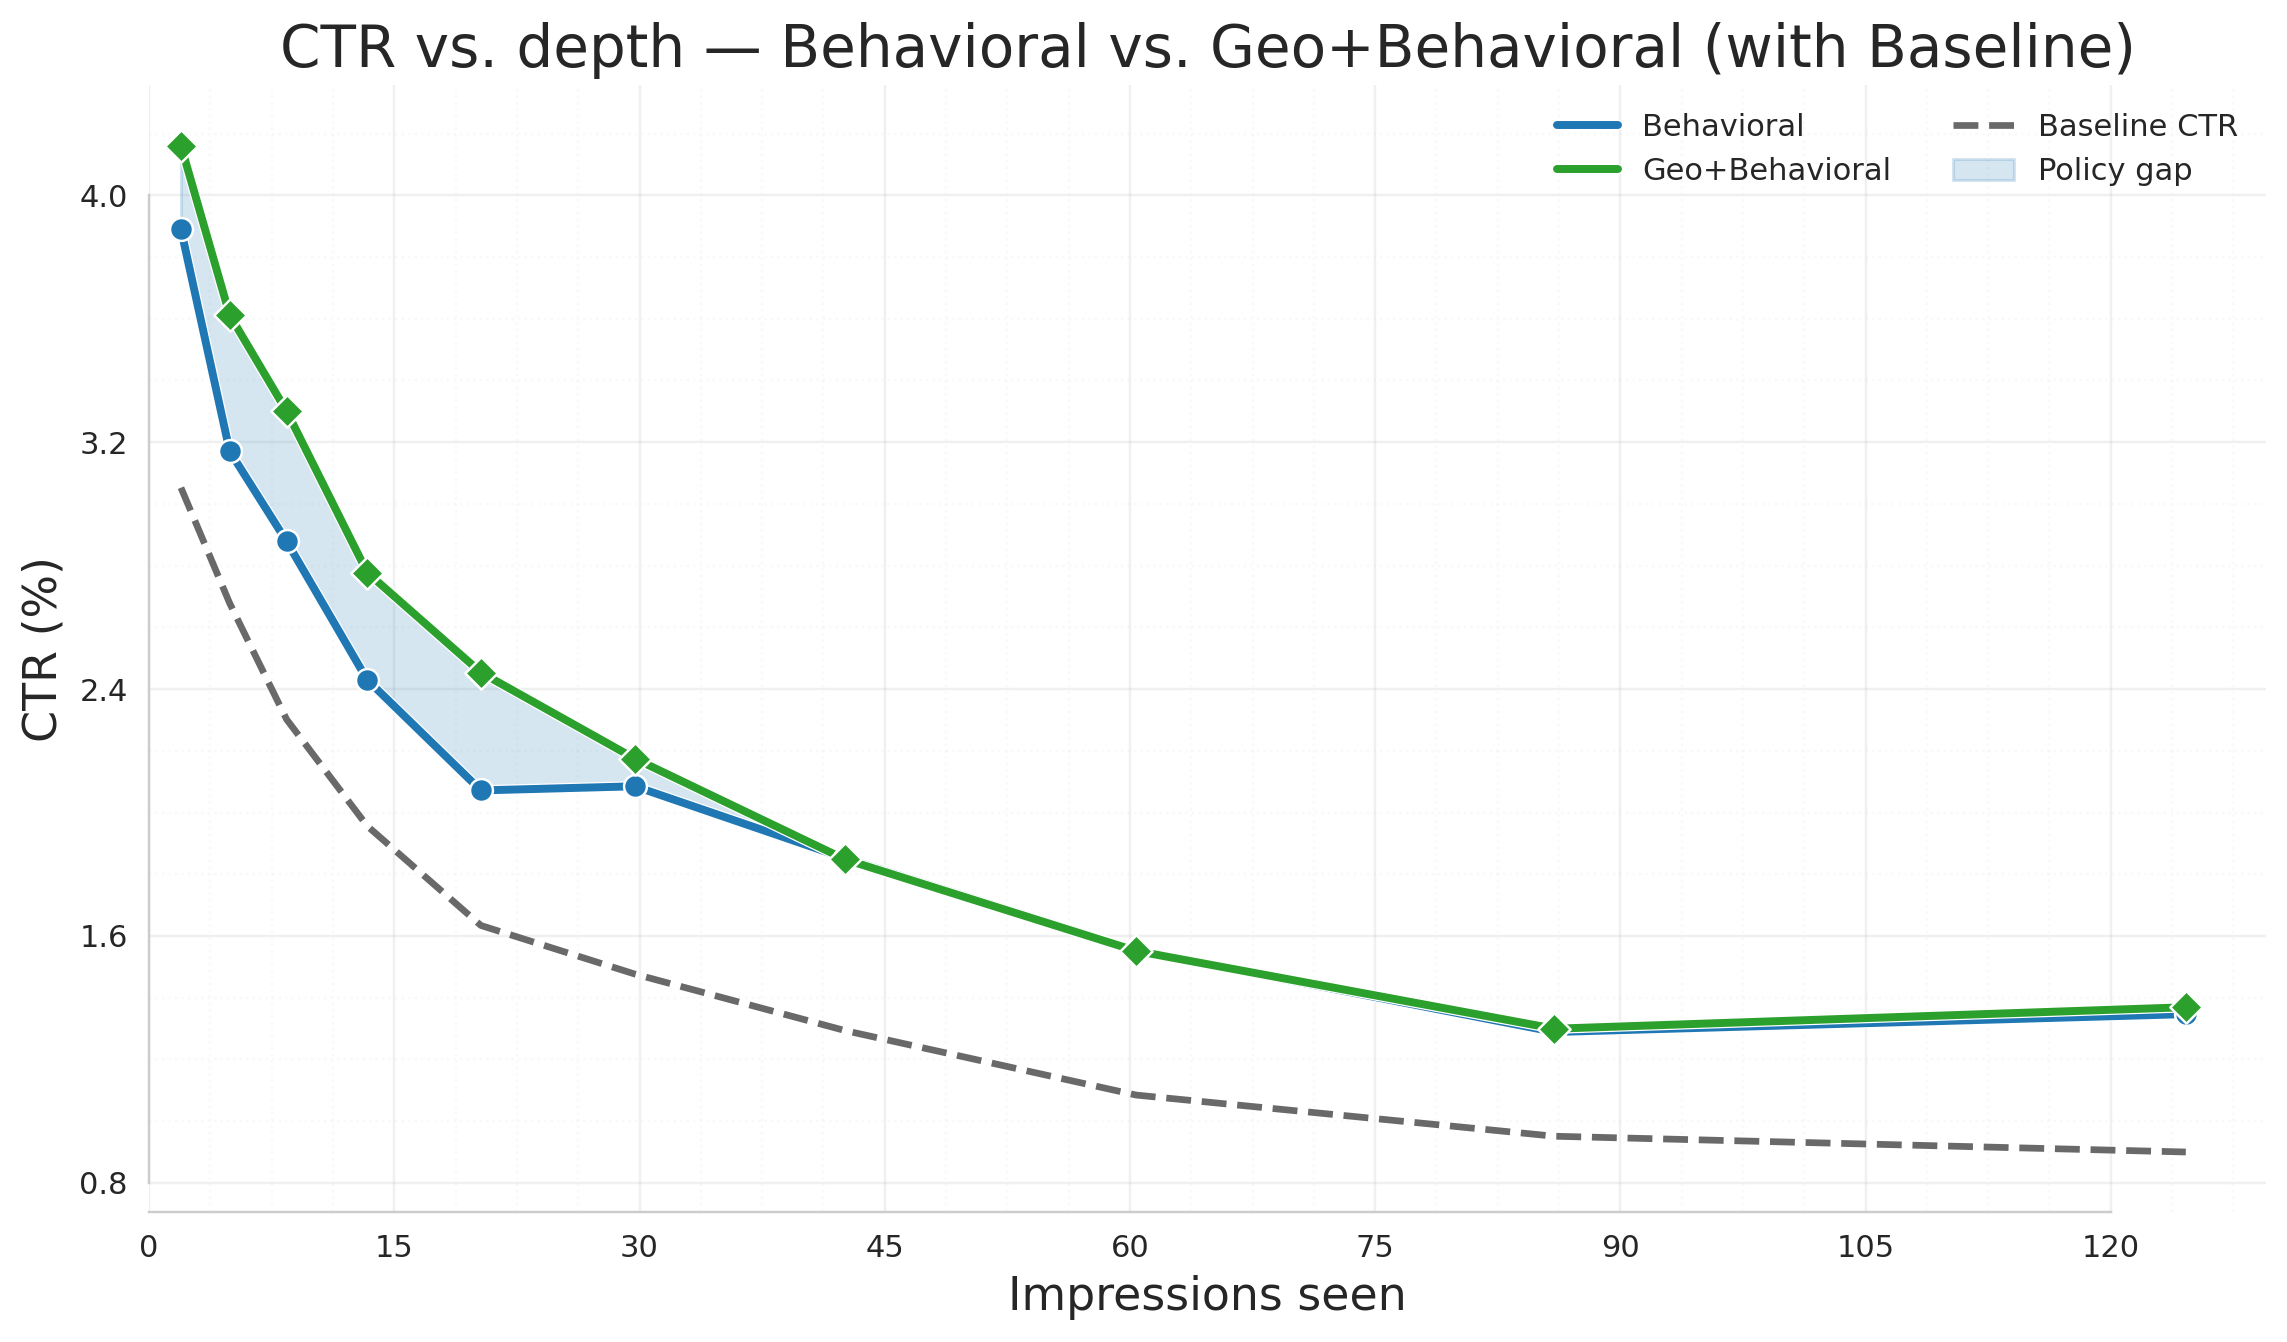

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as pe

sns.set_style("whitegrid")

STEP_FILES = {
    "C":  "policy_evaluation_step_by_step_Contextual.csv",
    "B":  "policy_evaluation_step_by_step_Behavioral.csv",
    "G":  "policy_evaluation_step_by_step_Geographical.csv",
    "GB": "policy_evaluation_step_by_step_BehavioralGeographical.csv",
}
RAW_FILE = "preprocessed_test_data.csv"
N_BINS = 10
MAX_IMPRESSIONS = 150

raw_ids = pd.read_csv(RAW_FILE, usecols=["Unique_ID", "ANDROID_ID"])
dfs = {}
for tag, path in STEP_FILES.items():
    df = pd.read_csv(path).merge(raw_ids, on="Unique_ID", how="left", validate="1:1")
    dfs[tag] = df

for tag, df in dfs.items():
    df.sort_values(["ANDROID_ID", "Unique_ID"], inplace=True)
    df["order_idx"] = df.groupby("ANDROID_ID").cumcount() + 1
    df = df[(0 < df["order_idx"]) & (df["order_idx"] <= MAX_IMPRESSIONS)]
    df["order_bin"] = pd.qcut(df["order_idx"], q=N_BINS, labels=False, duplicates="drop")
    dfs[tag] = df

records = []
for b in range(N_BINS):
    if not (dfs["B"]["order_bin"] == b).any():
        candidates = [dfs[k] for k in ["C", "G", "GB"] if (dfs[k]["order_bin"] == b).any()]
        if len(candidates) == 0:
            continue
        mid = candidates[0].loc[candidates[0]["order_bin"] == b, "order_idx"].mean()
    else:
        mid = dfs["B"].loc[dfs["B"]["order_bin"] == b, "order_idx"].mean()

    if (dfs["B"]["order_bin"] == b).any():
        ctr_base = dfs["B"].loc[dfs["B"]["order_bin"] == b, "Actual_Y"].mean()
    else:
        first_with_bin = next((dfs[k] for k in ["C", "G", "GB"] if (dfs[k]["order_bin"] == b).any()), None)
        ctr_base = np.nan if first_with_bin is None else first_with_bin.loc[first_with_bin["order_bin"] == b, "Actual_Y"].mean()

    rec = {"bin": b, "mid_impr": mid, "CTR_BASE": 100.0 * ctr_base if pd.notna(ctr_base) else np.nan}

    for tag, df in dfs.items():
        mask = df["order_bin"] == b
        ips = df.loc[mask, "ips_greedy_term"].mean() if mask.any() else np.nan
        rec[f"CTR_{tag}"] = 100.0 * ips if pd.notna(ips) else np.nan

    records.append(rec)

res = pd.DataFrame(records).sort_values("mid_impr").reset_index(drop=True)

def _masked_arrays(x, *ys):
    x = np.asarray(x, dtype=float)
    ys = [np.asarray(y, dtype=float) for y in ys]
    m = ~np.isnan(x)
    for y in ys:
        m &= ~np.isnan(y)
    return x[m], [y[m] for y in ys]

def _focus_window(x, y_list, baseline, pad_x=0.04, pad_y=0.06, gap_eps=0.02, dev_eps=0.03):
    x = np.asarray(x, float)
    Y = [np.asarray(y, float) for y in y_list]
    base = np.asarray(baseline, float)

    m = ~np.isnan(x)
    for y in Y + [base]:
        m &= ~np.isnan(y)
    if not m.any():
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        y_all = np.concatenate([np.nan_to_num(y, nan=np.nan) for y in Y + [base]])
        y_all = y_all[~np.isnan(y_all)]
        y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)
        return float(x_min), float(x_max), float(y_min), float(y_max)

    xv = x[m]; y1 = Y[0][m]; y2 = Y[1][m]; b = base[m]
    gap = np.abs(y1 - y2)
    dev = np.maximum(np.abs(y1 - b), np.abs(y2 - b))
    interesting = (gap >= gap_eps) | (dev >= dev_eps)

    xmax_focus = xv[np.where(interesting)[0].max()] if interesting.any() else xv.max()
    xmin_focus = xv.min()

    xspan = max(1.0, xmax_focus - xmin_focus)
    x_min = max(0.0, xmin_focus - pad_x * xspan)
    x_max = xmax_focus + pad_x * xspan

    in_focus = (xv >= x_min) & (xv <= x_max)
    y_all = np.concatenate([y1[in_focus], y2[in_focus], b[in_focus]])
    y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)

    yspan = max(0.2, y_max - y_min)
    y_min = max(0.0, y_min - pad_y * yspan)
    y_max = y_max + pad_y * yspan
    return float(x_min), float(x_max), float(y_min), float(y_max)

def make_ctr_plot(policy_pair, labels, markers, colors, title, fname):
    key1, key2 = policy_pair
    lab1, lab2 = labels
    mark1, mark2 = markers
    col1, col2 = colors

    x = res["mid_impr"].values
    y_base = res["CTR_BASE"].values
    y1 = res[f"CTR_{key1}"].values
    y2 = res[f"CTR_{key2}"].values

    x12, (y1m, y2m) = _masked_arrays(x, y1, y2)
    xb,  (ybm,)     = _masked_arrays(x, y_base)
    xall, (y1a, y2a, yba) = _masked_arrays(x, y1, y2, y_base)

    fig, ax = plt.subplots(figsize=(10.5, 6.2), dpi=220)
    ax.set_facecolor("white")

    outline = [pe.Stroke(linewidth=3.4, foreground="white"), pe.Normal()]
    ax.plot(x12, y1m, lw=2.6, color=col1, label=lab1, path_effects=outline)
    ax.scatter(x12, y1m, s=56, color=col1, marker=mark1, edgecolor="white", linewidth=0.8, zorder=3)
    ax.plot(x12, y2m, lw=2.6, color=col2, label=lab2, path_effects=outline)
    ax.scatter(x12, y2m, s=56, color=col2, marker=mark2, edgecolor="white", linewidth=0.8, zorder=3)

    ax.plot(xb, ybm, lw=2.2, color="dimgray", ls="--", label="Baseline CTR")

    xf, (yl, yh) = _masked_arrays(x, np.minimum(y1, y2), np.maximum(y1, y2))
    ax.fill_between(xf, yl, yh, color="tab:blue", alpha=0.18, label="Policy gap")

    xg, (ybl, ylp) = _masked_arrays(x, y_base, np.minimum(y1, y2))
    where_mask = ybl > ylp
    if where_mask.any():
        ax.fill_between(xg, ylp, ybl, where=where_mask, interpolate=True,
                        color="lightgray", alpha=0.55, label="Baseline above lower policy")

    x_min, x_max, y_min, y_max = _focus_window(xall, [y1a, y2a], yba)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.grid(True, which="major", alpha=0.28)
    ax.minorticks_on()
    ax.grid(True, which="minor", alpha=0.10, linestyle=":")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(6))

    ax.set_xlabel("Impressions seen", fontsize=15)
    ax.set_ylabel("CTR (%)", fontsize=15)
    ax.set_title(title, fontsize=19)

    ax.legend(frameon=False, ncol=2)
    sns.despine(trim=True)
    fig.tight_layout()
    fig.savefig(fname, dpi=220)
    print("✓ Saved →", fname)

make_ctr_plot(
    policy_pair=("C", "G"),
    labels=("Contextual", "Geographical"),
    markers=("^", "s"),
    colors=("C3", "C1"),
    title="CTR vs. depth — Contextual vs. Geographical (with Baseline)",
    fname="ctr_depth_C_vs_G.png",
)

make_ctr_plot(
    policy_pair=("B", "GB"),
    labels=("Behavioral", "Geo+Behavioral"),
    markers=("o", "D"),
    colors=("C0", "C2"),
    title="CTR vs. depth — Behavioral vs. Geo+Behavioral (with Baseline)",
    fname="ctr_depth_B_vs_GB.png",
)

## Table 4: Complementarity vs. Substitutability of Geographical and Behavioral Information

This table reports inverse propensity score (IPS)–based estimates of the interaction between geographic and behavioral information in ad targeting. We compute the difference-in-differences estimand
\[
\Delta = V(\text{Geo+Behav}) - V(\text{Behav}) - V(\text{Geo}) + V(\text{Contextual}),
\]
where policy values are evaluated using IPS at the impression level.

Standard errors are clustered at the user level to account for within-user dependence. The table reports the estimated interaction effect, clustered standard error, test statistics, confidence intervals, and one-sided tests for complementarity (\(\Delta>0\)) and substitutability (\(\Delta<0\)). The results classify the relationship between geographic and behavioral information as complementary, substitutable, or inconclusive.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

STEP_FILES = {
    "C":  "policy_evaluation_step_by_step_Contextual.csv",
    "B":  "policy_evaluation_step_by_step_Behavioral.csv",
    "G":  "policy_evaluation_step_by_step_Geographical.csv",
    "GB": "policy_evaluation_step_by_step_BehavioralGeographical.csv",
}
RAW_FILE = "preprocessed_test_data.csv"
IPS_COL = "ips_greedy_term"

MAX_IMPRESSIONS = 150
N_BINS = 10
ALPHA = 0.05
sns.set_style("whitegrid")

def cluster_robust_mean_se(d, clusters):
    d = np.asarray(d, dtype=float)
    clusters = np.asarray(clusters)
    ok = np.isfinite(d) & pd.notna(clusters)
    d = d[ok]
    clusters = clusters[ok]
    n = d.size
    if n == 0:
        raise ValueError("No finite observations for d_i.")
    m = d.mean()
    df = pd.DataFrame({"d": d, "cluster": clusters})
    df["dc"] = df["d"] - m
    Sg = df.groupby("cluster", sort=False)["dc"].sum()
    G = Sg.size
    if G < 2:
        se = np.sqrt(np.var(d, ddof=1) / n) if n > 1 else np.nan
        return m, se, max(n - 1, 1), G, n
    V_cr1 = (G / (G - 1)) * (np.sum(Sg.values**2) / (n**2))
    se = np.sqrt(V_cr1)
    dof = G - 1
    return m, se, dof, G, n

def test_and_ci(mean, se, dof, alpha=0.05):
    if not np.isfinite(se) or se == 0:
        tstat = np.inf if mean > 0 else (-np.inf if mean < 0 else 0.0)
        p_two = 0.0 if np.isfinite(tstat) else 1.0
        p_gt = 0.0 if tstat > 0 else 1.0
        p_lt = 0.0 if tstat < 0 else 1.0
        ci = (mean, mean)
        return {"t": tstat, "p_two": p_two, "p_gt": p_gt, "p_lt": p_lt, "ci": ci}
    tstat = mean / se
    p_two = 2 * stats.t.sf(np.abs(tstat), df=dof)
    p_gt = stats.t.sf(tstat, df=dof)
    p_lt = stats.t.cdf(tstat, df=dof)
    tcrit = stats.t.ppf(1 - alpha / 2, df=dof)
    ci = (mean - tcrit * se, mean + tcrit * se)
    return {"t": tstat, "p_two": p_two, "p_gt": p_gt, "p_lt": p_lt, "ci": ci}

raw_ids = pd.read_csv(RAW_FILE, usecols=["Unique_ID", "ANDROID_ID"])
dfs = {}
for tag, path in STEP_FILES.items():
    df = pd.read_csv(path, usecols=["Unique_ID", IPS_COL])
    df = df.merge(raw_ids, on="Unique_ID", how="left", validate="1:1")
    dfs[tag] = df

for k in ["C", "B", "G", "GB"]:
    if IPS_COL not in dfs[k].columns:
        raise ValueError(f"Missing '{IPS_COL}' in file for {k}.")

order_df = dfs["B"].copy()
order_df = order_df.sort_values(["ANDROID_ID", "Unique_ID"], kind="mergesort")
order_df["order_idx"] = order_df.groupby("ANDROID_ID").cumcount() + 1
order_df = order_df.loc[order_df["order_idx"] <= MAX_IMPRESSIONS].copy()
order_df["order_bin"] = pd.qcut(order_df["order_idx"], q=N_BINS, labels=False, duplicates="drop")

keep = order_df[["Unique_ID", "ANDROID_ID", "order_idx", "order_bin"]]
for k in dfs:
    dfs[k] = keep.merge(dfs[k], on=["Unique_ID", "ANDROID_ID"], how="left", validate="1:1")

wide = keep.copy()
wide = wide.merge(dfs["B"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_B"}), on="Unique_ID", how="left")
wide = wide.merge(dfs["G"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_G"}), on="Unique_ID", how="left")
wide = wide.merge(dfs["GB"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_GB"}), on="Unique_ID", how="left")
wide = wide.merge(dfs["C"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_C"}), on="Unique_ID", how="left")

wide = wide.dropna(subset=["ips_B", "ips_G", "ips_GB", "ips_C"]).reset_index(drop=True)
wide["d"] = wide["ips_GB"] - wide["ips_B"] - wide["ips_G"] + wide["ips_C"]

mean_all, se_all, dof_all, G_all, n_all = cluster_robust_mean_se(
    wide["d"].to_numpy(), wide["ANDROID_ID"].to_numpy()
)
res_all = test_and_ci(mean_all, se_all, dof_all, alpha=ALPHA)

def label_from_result(mean, p_gt, p_lt, alpha=0.05):
    if p_gt < alpha:
        return "Complement (Δ>0)"
    if p_lt < alpha:
        return "Substitute (Δ<0)"
    return "Inconclusive"

label_all = label_from_result(mean_all, res_all["p_gt"], res_all["p_lt"], ALPHA)

print("\n================  OVERALL COMPLEMENT vs. SUBSTITUTE  =================")
print(f"n impressions = {n_all:,}   |  clusters (ANDROID_ID) = {G_all:,}   |  dof = {dof_all}")
print(f"Δ̂ (overall)  = {mean_all:.6g}")
print(f"SE_clustered  = {se_all:.6g}")
print(f"t-stat        = {res_all['t']:.3f}")
print(f"95% CI        = [{res_all['ci'][0]:.6g}, {res_all['ci'][1]:.6g}]")
print(f"p (two-sided) = {res_all['p_two']:.4g}")
print(f"p (Δ>0)       = {res_all['p_gt']:.4g}")
print(f"p (Δ<0)       = {res_all['p_lt']:.4g}")
print(f"Decision @ α={ALPHA:.2g}:  {label_all}")



================  OVERALL COMPLEMENT vs. SUBSTITUTE  =================
n impressions = 3,162,376   |  clusters (ANDROID_ID) = 141,595   |  dof = 141594
Δ̂ (overall)  = 0.000509806
SE_clustered  = 0.000334048
t-stat        = 1.526
95% CI        = [-0.000144922, 0.00116453]
p (two-sided) = 0.127
p (Δ>0)       = 0.06349
p (Δ<0)       = 0.9365
Decision @ α=0.05:  Inconclusive


## Figure 7: Complementarity vs. Substitutability Across Impression Depth

This figure examines how the interaction between geographic and behavioral information evolves with user impression depth. The top panel plots IPS-estimated incremental policy lift with 95% confidence intervals for **Geo+Behavioral vs. Behavioral (GB−B)** and **Geographical vs. Contextual (G−C)** across bins of impression order. The bottom panel reports the difference-in-differences,
\[
\Delta = (GB-B) - (G-C),
\]
which isolates complementarity (\(\Delta>0\)) versus substitutability (\(\Delta<0\)).

Background shading indicates the direction and statistical strength of the interaction in each bin: green (complement), red (substitute), and gray (neither), with opacity reflecting significance thresholds. Together, the figure shows how the marginal value of combining geographic and behavioral information varies systematically as behavioral histories become richer.


✓ Ready → ctr_incremental_dualplot_legend (legend inside, two p tiers)


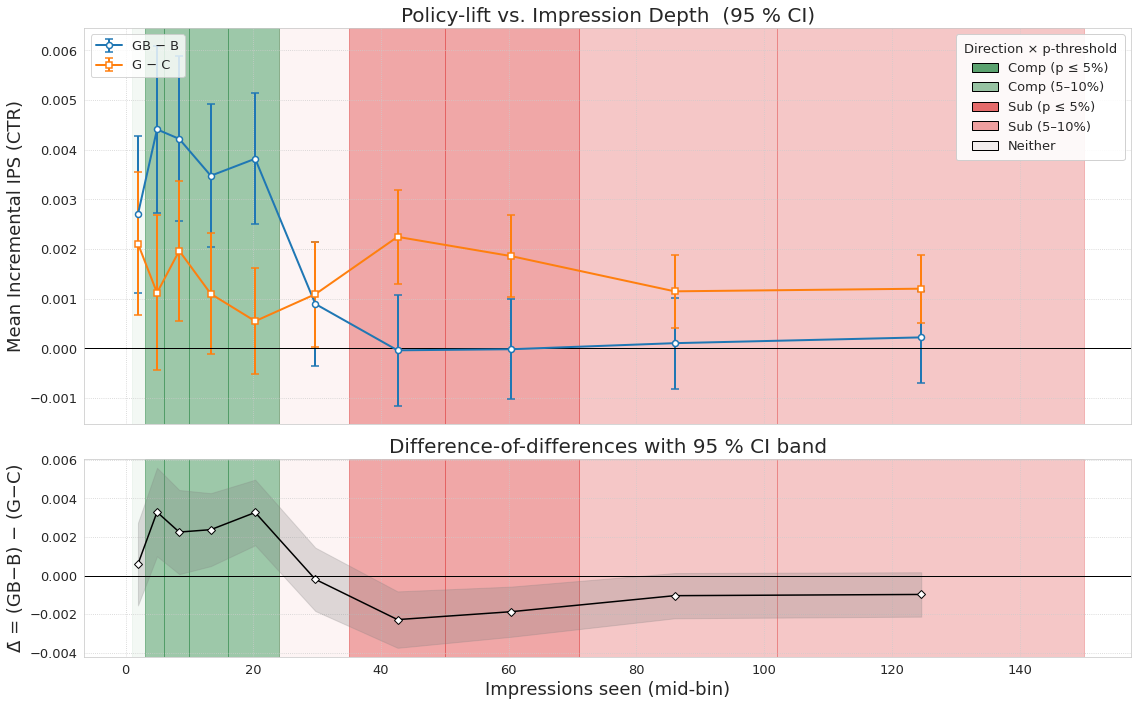

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats

STEP_FILES = {
    "C":  "policy_evaluation_step_by_step_Contextual.csv",
    "B":  "policy_evaluation_step_by_step_Behavioral.csv",
    "G":  "policy_evaluation_step_by_step_Geographical.csv",
    "GB": "policy_evaluation_step_by_step_BehavioralGeographical.csv",
}
RAW_FILE        = "preprocessed_test_data.csv"
N_BINS          = 10
MAX_IMPRESSIONS = 150

sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.rcParams.update({'font.size': 13})

ALPHA_TABLE = {
    "p5":   0.80,
    "p10":  0.50,
    "none": 0.10
}

def tier(p: float) -> str:
    if np.isnan(p):    return "none"
    if p <= 0.05:      return "p5"
    if p <= 0.10:      return "p10"
    return "none"

def rgba(status: str, p: float) -> tuple:
    base = {"substitute": (0.88, 0.28, 0.28),
            "complement": (0.20, 0.55, 0.30),
            "neither":    (0.55, 0.55, 0.55)}
    return (*base[status], ALPHA_TABLE[tier(p)])

raw_ids = pd.read_csv(RAW_FILE, usecols=["Unique_ID", "ANDROID_ID"])
dfs = {}
for tag, path in STEP_FILES.items():
    df = (pd.read_csv(path)
            .merge(raw_ids, on="Unique_ID")
            .sort_values(["ANDROID_ID", "Unique_ID"]))
    df["order_idx"] = df.groupby("ANDROID_ID").cumcount().add(1)
    df              = df.query("0 < order_idx <= @MAX_IMPRESSIONS")
    df["order_bin"] = pd.qcut(df["order_idx"], q=N_BINS,
                              labels=False, duplicates="drop")
    dfs[tag] = df

for tag in STEP_FILES:
    if "ips_greedy_term" not in dfs[tag].columns:
        raise ValueError(f"'{tag}' file lacks 'ips_greedy_term' column.")

rows = []
for b in range(N_BINS):
    mid = dfs["B"].loc[dfs["B"]["order_bin"] == b, "order_idx"].mean()

    gb   = dfs["GB"].loc[dfs["GB"]["order_bin"] == b,
                         ["Unique_ID", "ips_greedy_term"]].rename(
                            columns={"ips_greedy_term": "ips_greedy_term_GB"}
                         )
    beh  = dfs["B"].loc[dfs["B"]["order_bin"] == b,
                        ["Unique_ID", "ips_greedy_term"]].rename(
                            columns={"ips_greedy_term": "ips_greedy_term_B"}
                        )
    d_gb = (gb.set_index("Unique_ID")
              .join(beh.set_index("Unique_ID"), how="inner"))
    d_gb["d"] = d_gb["ips_greedy_term_GB"] - d_gb["ips_greedy_term_B"]
    n1, m1 = len(d_gb), d_gb["d"].mean()
    se1 = d_gb["d"].std(ddof=1) / np.sqrt(n1) if n1 > 1 else np.nan
    ci1 = stats.t.ppf(0.975, n1-1)*se1 if n1 > 1 else np.nan

    g_bin = dfs["G"].loc[dfs["G"]["order_bin"] == b,
                         ["Unique_ID", "ips_greedy_term"]].rename(
                            columns={"ips_greedy_term": "ips_greedy_term_G"}
                         )
    c_bin = dfs["C"].loc[dfs["C"]["order_bin"] == b,
                         ["Unique_ID", "ips_greedy_term"]].rename(
                            columns={"ips_greedy_term": "ips_greedy_term_C"}
                         )
    d_gc = (g_bin.set_index("Unique_ID")
                 .join(c_bin.set_index("Unique_ID"), how="inner"))
    d_gc["d"] = d_gc["ips_greedy_term_G"] - d_gc["ips_greedy_term_C"]
    n2, m2 = len(d_gc), d_gc["d"].mean()
    se2 = d_gc["d"].std(ddof=1) / np.sqrt(n2) if n2 > 1 else np.nan
    ci2 = stats.t.ppf(0.975, n2-1)*se2 if n2 > 1 else np.nan

    if n1 > 1 and n2 > 1 and np.isfinite(se1) and np.isfinite(se2):
        seD = np.hypot(se1, se2)
        t   = (m1 - m2)/seD if seD > 0 else np.nan
        p   = 2*stats.t.sf(abs(t), df=min(n1, n2)-1) if np.isfinite(t) else np.nan
    else:
        p = np.nan

    status = ("substitute" if m1 < m2 else
              "complement" if m1 > m2 else "neither")

    rows.append(dict(bin=b, mid=mid, mean_gb=m1, ci_gb=ci1,
                     mean_g=m2, ci_g=ci2, delta=m1-m2,
                     p=p, status=status, tier=tier(p)))

res = pd.DataFrame(rows)

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(16, 10),
                                     sharex=True,
                                     gridspec_kw={'height_ratios': [2, 1]})

edges = dfs["B"]["order_idx"].quantile(np.linspace(0, 1, N_BINS+1)).values
for i in range(N_BINS):
    col = rgba(res.at[i, "status"], res.at[i, "p"])
    ax_top.axvspan(edges[i], edges[i+1], color=col, alpha=col[-1]*0.6, zorder=0)
    ax_bot.axvspan(edges[i], edges[i+1], color=col, alpha=col[-1]*0.6, zorder=0)

ax_top.errorbar(res["mid"], res["mean_gb"], yerr=res["ci_gb"],
                fmt="o-", lw=2, capsize=4, color="#1f77b4",
                markerfacecolor="white", markeredgewidth=1.5, label="GB − B")
ax_top.errorbar(res["mid"], res["mean_g"], yerr=res["ci_g"],
                fmt="s-", lw=2, capsize=4, color="#ff7f0e",
                markerfacecolor="white", markeredgewidth=1.5, label="G − C")
ax_top.axhline(0, color="k", lw=1)
ax_top.set_ylabel("Mean Incremental IPS (CTR)", fontsize=18)
ax_top.set_title("Policy-lift vs. Impression Depth  (95 % CI)", fontsize=20)

ax_bot.plot(res["mid"], res["delta"], "D-", color="black",
            markerfacecolor="white", lw=1.5)
ax_bot.fill_between(res["mid"],
                    res["delta"]-np.hypot(res["ci_gb"], res["ci_g"]),
                    res["delta"]+np.hypot(res["ci_gb"], res["ci_g"]),
                    color="grey", alpha=0.25)
ax_bot.axhline(0, color="k", lw=1)
ax_bot.set_ylabel("Δ̄ = (GB−B) − (G−C)", fontsize=18)
ax_bot.set_xlabel("Impressions seen (mid-bin)", fontsize=18)
ax_bot.set_title("Difference-of-differences with 95 % CI band", fontsize=20)

series_handles, series_labels = ax_top.get_legend_handles_labels()
leg1 = ax_top.legend(series_handles, series_labels, loc="upper left")

patches, labels = [], []
for dir_key, dir_lbl in [("complement", "Comp"), ("substitute", "Sub")]:
    patches.append(Patch(facecolor=rgba(dir_key, 0.049), edgecolor='k'))
    labels.append(f"{dir_lbl} (p ≤ 5%)")
    patches.append(Patch(facecolor=rgba(dir_key, 0.075), edgecolor='k'))
    labels.append(f"{dir_lbl} (5–10%)")

patches.append(Patch(facecolor=rgba("neither", np.nan), edgecolor='k'))
labels.append("Neither")

leg2 = ax_top.legend(
    patches, labels,
    title="Direction × p-threshold",
    loc="upper right",
    frameon=True, framealpha=0.9, fancybox=True, borderpad=0.6
)
ax_top.add_artist(leg1)

plt.tight_layout()
plt.savefig("Fig_ctr_incremental_dualplot_legend.png", dpi=150, bbox_inches="tight")
print("✓ Ready → ctr_incremental_dualplot_legend (legend inside, two p tiers)")

## Bin-Level Complementarity Test Across Behavioral History Depth (Table A4)

This procedure implements a **bin-level difference-in-differences test** to assess how the interaction between geographic and behavioral information varies with user behavioral history depth. Impressions are ordered within user and partitioned into quantile bins of impression index (up to the first 150 impressions).

For each impression \( i \), we compute the interaction term
\[
\Delta_i \;=\; (\text{IPS}_{GB,i} - \text{IPS}_{B,i}) \;-\; (\text{IPS}_{G,i} - \text{IPS}_{C,i}),
\]
which isolates the incremental value of combining geographic and behavioral information relative to their standalone contributions.

Within each impression-depth bin, we estimate the mean interaction effect \( \hat\Delta \) using **cluster-robust inference at the user level** to account for within-user dependence. We report clustered standard errors, degrees of freedom, two-sided and one-sided \(t\)-tests, and 95% confidence intervals.

Each bin is classified as **Complement**, **Substitute**, or **Inconclusive** based on one-sided tests of \( \hat\Delta>0 \) or \( \hat\Delta<0 \), with significance tiers (strong/moderate/weak) reflecting conventional thresholds. This analysis provides a fine-grained view of how information complementarity evolves as behavioral histories transition from sparse to rich.


In [3]:
import numpy as np
import pandas as pd
from scipy import stats

STEP_FILES = {
    "C":  "policy_evaluation_step_by_step_CCC.csv",
    "B":  "policy_evaluation_step_by_step_Beh3.csv",
    "G":  "policy_evaluation_step_by_step_XG_Geo311.csv",
    "GB": "policy_evaluation_step_by_step_GeoBeh3.csv",
}
RAW_FILE        = "preprocessed_test_data.csv"
IPS_COL         = "ips_greedy_term"
N_BINS          = 10
MAX_IMPRESSIONS = 150
ALPHA           = 0.05

def cluster_robust_mean_se(d, clusters):
    df = pd.DataFrame({"d": d, "g": clusters})
    df = df[np.isfinite(df["d"]) & df["g"].notna()]
    n = len(df)
    if n == 0:
        return np.nan, np.nan, np.nan, 0, 0
    m = df["d"].mean()
    Sg = (df["d"] - m).groupby(df["g"], sort=False).sum()
    G = Sg.size
    if G < 2:
        se = df["d"].std(ddof=1) / np.sqrt(n) if n > 1 else np.nan
        return m, se, max(n - 1, 1), G, n
    V_cr1 = (G / (G - 1)) * (np.sum(Sg.values ** 2) / (n ** 2))
    se = np.sqrt(V_cr1)
    dof = G - 1
    return m, se, dof, G, n

def test_and_ci(mean, se, dof, alpha=0.05):
    if not np.isfinite(se) or se == 0 or not np.isfinite(mean):
        return dict(t=np.nan, p_two=np.nan, p_gt=np.nan, p_lt=np.nan,
                    ci=(np.nan, np.nan))
    tstat = mean / se
    p_two = 2 * stats.t.sf(abs(tstat), df=dof)
    p_gt  = stats.t.sf(tstat, df=dof)
    p_lt  = stats.t.cdf(tstat, df=dof)
    tcrit = stats.t.ppf(1 - alpha / 2, df=dof)
    ci = (mean - tcrit * se, mean + tcrit * se)
    return dict(t=tstat, p_two=p_two, p_gt=p_gt, p_lt=p_lt, ci=ci)

def tier_one_sided(mean, p_gt, p_lt):
    if not np.isfinite(mean) or not np.isfinite(p_gt) or not np.isfinite(p_lt):
        return "Inconclusive", "none"
    p_dir = p_gt if mean > 0 else (p_lt if mean < 0 else np.nan)
    if not np.isfinite(p_dir):
        return "Inconclusive", "none"
    if p_dir <= 0.01: return ("Complement" if mean > 0 else "Substitute"), "strong"
    if p_dir <= 0.05: return ("Complement" if mean > 0 else "Substitute"), "mod"
    if p_dir <= 0.10: return ("Complement" if mean > 0 else "Substitute"), "weak"
    return "Inconclusive", "none"

raw_ids = pd.read_csv(RAW_FILE, usecols=["Unique_ID", "ANDROID_ID"])
dfs = {}
for tag, path in STEP_FILES.items():
    df = pd.read_csv(path, usecols=["Unique_ID", IPS_COL])
    df = df.merge(raw_ids, on="Unique_ID", how="left", validate="1:1")
    dfs[tag] = df

B = dfs["B"].sort_values(["ANDROID_ID", "Unique_ID"], kind="mergesort")
B["order_idx"] = B.groupby("ANDROID_ID").cumcount() + 1
B = B.loc[B["order_idx"] <= MAX_IMPRESSIONS].copy()
B["order_bin"] = pd.qcut(B["order_idx"], q=N_BINS, labels=False, duplicates="drop")

bins = B[["Unique_ID", "ANDROID_ID", "order_idx", "order_bin"]].copy()
for k in dfs:
    dfs[k] = bins.merge(dfs[k], on=["Unique_ID", "ANDROID_ID"], how="left", validate="1:1")

wide = bins.copy()
wide = wide.merge(dfs["GB"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_GB"}), on="Unique_ID", how="left")
wide = wide.merge(dfs["B"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_B"}),  on="Unique_ID", how="left")
wide = wide.merge(dfs["G"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_G"}),  on="Unique_ID", how="left")
wide = wide.merge(dfs["C"][["Unique_ID", IPS_COL]].rename(columns={IPS_COL: "ips_C"}),  on="Unique_ID", how="left")

wide = wide.dropna(subset=["ips_GB", "ips_B", "ips_G", "ips_C"]).reset_index(drop=True)
wide["d"] = (wide["ips_GB"] - wide["ips_B"]) - (wide["ips_G"] - wide["ips_C"])

rows = []
for b in sorted(wide["order_bin"].dropna().unique()):
    sub = wide.loc[wide["order_bin"] == b]
    if sub.empty:
        continue
    m, se, dof, G, n = cluster_robust_mean_se(sub["d"].to_numpy(), sub["ANDROID_ID"].to_numpy())
    out = test_and_ci(m, se, dof, alpha=ALPHA)
    direction, tier = tier_one_sided(m, out["p_gt"], out["p_lt"])
    rows.append({
        "Bin": int(b),
        "Last-Impr": int(sub["order_idx"].max()),
        "n": int(n),
        "clusters": int(G),
        "df": float(dof),
        "Delta_hat": float(m),
        "SE_cluster": float(se) if np.isfinite(se) else np.nan,
        "CI_low": float(out["ci"][0]),
        "CI_high": float(out["ci"][1]),
        "t_stat": float(out["t"]),
        "p_two": float(out["p_two"]),
        "p_gt (Δ>0)": float(out["p_gt"]),
        "p_lt (Δ<0)": float(out["p_lt"]),
        "Decision": direction,
        "SignifTier": tier
    })

table = pd.DataFrame(rows).sort_values(["Last-Impr"]).reset_index(drop=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda v: f"{v:,.6f}")
print(table.to_string(index=False))


Complement vs. Substitute by impression depth (clustered DoD test)
(d_i = (GB−B) − (G−C), clustered by ANDROID_ID; α = 0.05)

 Bin  Last-Impr      n  clusters             df  Delta_hat  SE_cluster    CI_low   CI_high    t_stat    p_two  p_gt (Δ>0)  p_lt (Δ<0)     Decision SignifTier
   0          3 403680    141595 141,594.000000   0.000594    0.001183 -0.001725  0.002912  0.501996 0.615671    0.307836    0.692164 Inconclusive       none
   1          6 287331    105997 105,996.000000   0.003291    0.001252  0.000836  0.005745  2.627985 0.008590    0.004295    0.995705   Complement     strong
   2         10 284874     79151  79,150.000000   0.002253    0.001214 -0.000126  0.004632  1.856148 0.063436    0.031718    0.968282   Complement        mod
   3         16 316821     60109  60,108.000000   0.002378    0.001067  0.000287  0.004470  2.228980 0.025819    0.012909    0.987091   Complement        mod
   4         24 310399     44403  44,402.000000   0.003270    0.000970  0.001370  0